# EBM Training on Google Colab Pro+ (A100)

This notebook trains an Energy-Based Model (EBM) to learn the energy landscape of UC/DR/Storage binary variables from MILP solutions, conditioned on Hierarchical Temporal Encoder embeddings.

## Hardware Requirements
- **GPU**: A100 (40 or 80 GB VRAM)
- **RAM**: 50+ GB (High RAM runtime)
- **Storage**: 100+ GB on Drive

## Setup
1. Upload your `benchmark` repo to Google Drive
2. Select Runtime → Change runtime type → A100 GPU + High RAM
3. Run cells in order

---

## 1. Mount Google Drive and Setup Paths

In [ ]:
# Mount Google Drive
from google.colab import drive
import os
import sys

drive.mount('/content/drive')

# Set paths - ADJUST THIS to match your Drive structure
REPO_PATH = '/content/drive/MyDrive/benchmark'
EMBEDDING_FILE = 'outputs/encoders/hierarchical_temporal/embeddings_multiscale_normalized.pt'
SCENARIOS_DIR = 'outputs/scenarios_v1_filtered'
SCENARIO_DIR_EVAL = 'outputs/scenarios_v1/eval'
OUTPUT_DIR = 'outputs/ebm_models'

# Add repo to Python path
sys.path.insert(0, REPO_PATH)

# Verify paths exist
print(f"Repo path: {REPO_PATH}")
print(f"Repo exists: {os.path.exists(REPO_PATH)}")
print(f"Embeddings path: {os.path.join(REPO_PATH, EMBEDDING_FILE)}")
print(f"Embeddings exist: {os.path.exists(os.path.join(REPO_PATH, EMBEDDING_FILE))}")
print(f"Scenarios exist: {os.path.exists(os.path.join(REPO_PATH, SCENARIOS_DIR))}")
print(f"Scenario EVAL: {os.path.exists(os.path.join(REPO_PATH, SCENARIO_DIR_EVAL))}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Repo path: /content/drive/MyDrive/benchmark
Repo exists: True
Embeddings path: /content/drive/MyDrive/benchmark/outputs/encoders/hierarchical_temporal/embeddings_multiscale_normalized.pt
Embeddings exist: True
Scenarios exist: True
Scenario EVAL: True


## 2. Install Dependencies

In [ ]:
# Install required packages
# !pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# !pip install -q torch-geometric torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
# !pip install -q wandb tqdm pandas numpy scipy

import torch

print("🔄 Installing PyTorch 2.5.1 and PyTorch Geometric...")

# Uninstall existing packages to ensure a clean slate
!pip uninstall -y torch torchvision torchaudio torch-scatter torch-sparse torch-geometric

# Install PyTorch 2.5.1 + CUDA 12.4
!pip install -q torch==2.5.1+cu124 torchvision==0.20.1+cu124 torchaudio==2.5.1+cu124 --index-url https://download.pytorch.org/whl/cu124

# Install PyG dependencies with matching wheels
!pip install -q torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-2.5.1+cu124.html
!pip install -q torch-geometric

# Install other dependencies
!pip install -q wandb numpy scipy tqdm pandas thrml

print("✓ Dependencies installed")

🔄 Installing PyTorch 2.5.1 and PyTorch Geometric...
Found existing installation: torch 2.9.0+cu126
Uninstalling torch-2.9.0+cu126:
  Successfully uninstalled torch-2.9.0+cu126
Found existing installation: torchvision 0.24.0+cu126
Uninstalling torchvision-0.24.0+cu126:
  Successfully uninstalled torchvision-0.24.0+cu126
Found existing installation: torchaudio 2.9.0+cu126
Uninstalling torchaudio-2.9.0+cu126:
  Successfully uninstalled torchaudio-2.9.0+cu126
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.2/908.2 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 112.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 103.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 109.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 139.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8

## 3. Check GPU and System Info

In [ ]:
import torch
import subprocess

# Check GPU
print("=" * 60)
print("SYSTEM INFORMATION")
print("=" * 60)

# GPU Info
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"GPU: {gpu_name}")
    print(f"GPU Memory: {gpu_memory:.1f} GB")
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"PyTorch Version: {torch.__version__}")

    # Verify it's A100
    if 'A100' in gpu_name:
        print("✓ A100 GPU detected!")
    else:
        print(f"⚠️  Warning: Expected A100, got {gpu_name}")
        print("   Change runtime: Runtime → Change runtime type → A100")
else:
    print("❌ No GPU detected!")
    print("   Enable GPU: Runtime → Change runtime type → GPU")

# RAM Info
try:
    mem_info = !cat /proc/meminfo | grep MemTotal
    mem_gb = int(mem_info[0].split()[1]) / 1e6
    print(f"\nRAM: {mem_gb:.1f} GB")
    if mem_gb > 45:
        print("✓ High RAM runtime detected!")
    else:
        print("⚠️  Consider using High RAM runtime for better performance")
except:
    print("\nCouldn't detect RAM")

# Disk Space
disk_info = !df -h /content
print(f"\nDisk Space:\n{disk_info[1]}")

print("=" * 60)

SYSTEM INFORMATION
GPU: NVIDIA A100-SXM4-80GB
GPU Memory: 85.2 GB
CUDA Version: 12.4
PyTorch Version: 2.5.1+cu124
✓ A100 GPU detected!

RAM: 175.2 GB
✓ High RAM runtime detected!

Disk Space:
overlay         236G   47G  190G  20% /


## 4. Import EBM Modules

In [ ]:
import os

os.chdir(REPO_PATH)

from torch.utils.data import DataLoader, random_split, Dataset
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch.nn as nn
from torch_geometric.nn import global_add_pool
import torch.optim as optim
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import json
from datetime import datetime

from src.ebm import (
    EnergyModel,
    StructuredEnergyModel,
    GibbsSampler,
    SGLDSampler,
    # PersistentContrastiveDivergence, # Removed due to ImportError
    MILPBinaryDataset,
    EBMTrainer,
    # ScheduledEBMTrainer,
    EBMMetrics,
    # TemporalMetrics,
    EmbeddingLoader,
    # collate_ebm_batch,
)

from src.ebm.model import GraphEnergyModel
from src.ebm.sampler import PersistentContrastiveDivergence, GraphSampler
from src.ebm.dataset import collate_ebm_batch, GraphBinaryDataset
from src.ebm.trainer import EBMTrainer, ScheduledEBMTrainer
from src.ebm.metrics import TemporalMetrics

print("✓ Modules imported successfully")

✓ Modules imported successfully


## 5. Configuration

In [ ]:
# Training Configuration
import shutil

# Define paths
drive_embedding_path = os.path.join(REPO_PATH, EMBEDDING_FILE)
local_embedding_path = '/content/embeddings_multiscale_normalized.pt'

# Copy file if not present locally
if not os.path.exists(local_embedding_path):
    print(f"🔄 Copying embeddings to local disk for faster I/O...")
    print(f"   Source: {drive_embedding_path}")
    print(f"   Dest:   {local_embedding_path}")
    print("   ⏳ This may take 4 minutes...")
    shutil.copy(drive_embedding_path, local_embedding_path)
    print("   ✓ Copy complete!")
else:
    print(f"✓ Embeddings already found locally: {local_embedding_path}")

CONFIG = {
    # Data
    'scenarios_dir': os.path.join(REPO_PATH, SCENARIOS_DIR),
    'scenarios_dir_eval': os.path.join(REPO_PATH, SCENARIO_DIR_EVAL),
    'embedding_file': local_embedding_path, # Updated to local path
    'output_dir': os.path.join(REPO_PATH, OUTPUT_DIR),

    # Model
    'model_type': 'structured',  # 'basic', 'structured', or 'factorized'
    'hidden_dims': [256, 256, 64],
    'use_quadratic': True,
    'quadratic_rank': 16,
    'activation': 'gelu',
    'dropout': 0.1,

    # Data loading
    'embedding_loading_mode': 'full',  # 'full' or 'lazy' - use full on A100!
    'temporal': False,  # Set True for temporal EBM
    'temporal_aggregation': 'mean',  # 'mean', 'max', 'last', 'first'

    # Training
    'batch_size': 128,  # Large batches for A100
    'num_epochs': 100,
    'learning_rate': 1e-4,
    'weight_decay': 1e-5,
    'gradient_clip': 1.0,

    # Sampling
    'sampler_type': 'pcd',  # 'gibbs', 'sgld', or 'pcd'
    'num_gibbs_steps': 5,  # Reduced from 50 to 5 for PCD (10x speedup)
    'temperature': 1.0,
    'initial_temperature': 2.0,
    'final_temperature': 1.0,
    'use_pcd': True,
    'num_pcd_chains': 128, # Reduced from 2000 to 128 to fix latency bottleneck

    # Training dynamics
    'num_negative_samples': 1,
    'use_amp': True,  # Mixed precision for A100
    'num_workers': 0,  # Parallel data loading

    # Evaluation
    'validate_every': 5,
    'save_every': 10,

    # Logging
    'use_wandb': False,  # Set True to log to W&B
    'wandb_project': 'milp-ebm',
    'wandb_name': f'ebm_a100_{datetime.now().strftime("%Y%m%d_%H%M%S")}',

    # Device
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'seed': 42,
}

# Set random seed
torch.manual_seed(CONFIG['seed'])
np.random.seed(CONFIG['seed'])

# Create output directory
os.makedirs(CONFIG['output_dir'], exist_ok=True)

# Print configuration
print("\n" + "=" * 60)
print("TRAINING CONFIGURATION")
print("=" * 60)
for key, value in CONFIG.items():
    if not key.startswith('_'):
        print(f"{key:25s}: {value}")
print("=" * 60 + "\n")

🔄 Copying embeddings to local disk for faster I/O...
   Source: /content/drive/MyDrive/benchmark/outputs/encoders/hierarchical_temporal/embeddings_multiscale_normalized.pt
   Dest:   /content/embeddings_multiscale_normalized.pt
   ⏳ This may take 7 minutes...
   ✓ Copy complete!

TRAINING CONFIGURATION
scenarios_dir            : /content/drive/MyDrive/benchmark/outputs/scenarios_v1_filtered
scenarios_dir_eval       : /content/drive/MyDrive/benchmark/outputs/scenarios_v1/eval
embedding_file           : /content/embeddings_multiscale_normalized.pt
output_dir               : /content/drive/MyDrive/benchmark/outputs/ebm_models
model_type               : structured
hidden_dims              : [256, 256, 64]
use_quadratic            : True
quadratic_rank           : 16
activation               : gelu
dropout                  : 0.1
embedding_loading_mode   : full
temporal                 : False
temporal_aggregation     : mean
batch_size               : 128
num_epochs               : 100
learn

## 6. Load Dataset with Full Embeddings

In [ ]:
import torch
import json
import os
from pathlib import Path

# Config
REPO_PATH = Path('/content/drive/MyDrive/benchmark')
EMBEDDING_PATH = Path('/content/embeddings_multiscale_normalized.pt')
OUTPUT_PATH = Path('/content/embeddings_ready_for_ebm.pt')
DATASET_INDEX = REPO_PATH / 'outputs/graphs/hetero_temporal_v1/dataset_index.json'

print("🔧 Reformatting embeddings for EBM loader...")

# 1. Charger les embeddings bruts
print(f"📂 Loading raw embeddings from {EMBEDDING_PATH}...")
# Note: weights_only=False est nécessaire ici car c'est un dict complexe
raw_data = torch.load(EMBEDDING_PATH, map_location='cpu')
all_embeddings = raw_data['embeddings']

# 2. Charger l'index pour avoir les IDs (noms de fichiers)
print(f"📖 Loading dataset index from {DATASET_INDEX}...")
with open(DATASET_INDEX, 'r') as f:
    index_data = json.load(f)

scenario_ids = []
for entry in index_data['entries']:
    # On récupère le nom de fichier sans l'extension .json ou .npz
    # Ex: "data/graph_0.npz" -> "graph_0"
    # Adaptez selon ce que votre dataset attend comme ID
    fname = os.path.basename(entry['graph_file'])
    scenario_ids.append(fname)

print(f"   Found {len(scenario_ids)} scenario IDs.")

# 3. Choisir quel niveau de hiérarchie utiliser comme contexte 'h'
# Pour un EBM global, on utilise souvent 'nation' (1 vecteur par temps)
LEVEL_TO_USE = 'nation'

print(f"⚙️ Extracting level: '{LEVEL_TO_USE}'...")
emb_list = all_embeddings[LEVEL_TO_USE]

# 4. Concaténer la liste en un seul tenseur
# emb_list est une liste de tenseurs [Batch_Size, Nodes, Time, Dim]
print("   Concatenating batches (this fixes the 'list' error)...")
if isinstance(emb_list, list):
    full_tensor = torch.cat(emb_list, dim=0)
else:
    full_tensor = emb_list

print(f"   Final Tensor Shape: {full_tensor.shape}")


# 5. Créer le dictionnaire {scenario_id: embedding}
print("📚 Building scenario dictionary...")
formatted_dict = {}

num_scenarios = len(scenario_ids)
total_rows = full_tensor.shape[0]

# On déduit T automatiquement
if total_rows % num_scenarios != 0:
    raise ValueError(f"❌ Mismatch! {total_rows} lignes ne se divisent pas par {num_scenarios} scénarios.")

T = total_rows // num_scenarios
print(f"   Detected Time Horizon T = {T}")
print(f"   Structure: [Total_Rows, Dim] -> we will slice every {T} rows.")

if LEVEL_TO_USE == 'nation':
    for i, sc_id in enumerate(scenario_ids):
        # On calcule les indices de début et de fin pour ce scénario
        start_idx = i * T
        end_idx = (i + 1) * T

        # On découpe la tranche correspondante
        # Shape obtenue : [T, 128] (ex: [24, 128])
        scenario_tensor = full_tensor[start_idx:end_idx, :].clone()

        formatted_dict[sc_id] = scenario_tensor

# 6. Sauvegarder
print(f"💾 Saving reformatted embeddings to {OUTPUT_PATH}...")
torch.save(formatted_dict, OUTPUT_PATH)

print("✅ Done! Update your CONFIG to use this new file.")

🔧 Reformatting embeddings for EBM loader...
📂 Loading raw embeddings from /content/embeddings_multiscale_normalized.pt...


/tmp/ipython-input-49574020.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  raw_data = torch.load(EMBEDDING_PATH, map_location='cpu')


📖 Loading dataset index from /content/drive/MyDrive/benchmark/outputs/graphs/hetero_temporal_v1/dataset_index.json...
   Found 2960 scenario IDs.
⚙️ Extracting level: 'nation'...
   Concatenating batches (this fixes the 'list' error)...
   Final Tensor Shape: torch.Size([71040, 128])
📚 Building scenario dictionary...
   Detected Time Horizon T = 24
   Structure: [Total_Rows, Dim] -> we will slice every 24 rows.
💾 Saving reformatted embeddings to /content/embeddings_ready_for_ebm.pt...
✅ Done! Update your CONFIG to use this new file.


In [ ]:
import torch
import os

# Chemins
INPUT_PATH = '/content/embeddings_ready_for_ebm.pt'
OUTPUT_PATH = '/content/embeddings_ready_for_ebm_clean.pt'

print("🧹 Cleaning embedding keys...")

# 1. Charger le dictionnaire actuel
data = torch.load(INPUT_PATH, map_location='cpu')
print(f"   Loaded {len(data)} entries.")

# Afficher un exemple "sale"
dirty_key = list(data.keys())[0]
print(f"   Dirty key example: '{dirty_key}'")

# 2. Nettoyer les clés
clean_data = {}
for key, tensor in data.items():
    # 1. Remplacer les backslashes Windows par des slashs (pour compatibilité Linux)
    standard_path = key.replace('\\', '/')

    # 2. Garder uniquement le nom de fichier (basename)
    filename = os.path.basename(standard_path)

    # 3. Enlever l'extension (.npz) pour avoir l'ID pur
    clean_id = os.path.splitext(filename)[0]

    clean_data[clean_id] = tensor

# Afficher un exemple "propre"
clean_key = list(clean_data.keys())[0]
print(f"   Clean key example: '{clean_key}'")

# 3. Sauvegarder
print(f"💾 Saving clean embeddings to {OUTPUT_PATH}...")
torch.save(clean_data, OUTPUT_PATH)

print("✅ Done! Update your CONFIG to use this clean file.")

🧹 Cleaning embedding keys...
   Loaded 2960 entries.
   Dirty key example: 'outputs\graphs\hetero_temporal_v1\scenario_00001.npz'
   Clean key example: 'scenario_00001'
💾 Saving clean embeddings to /content/embeddings_ready_for_ebm_clean.pt...


/tmp/ipython-input-4020600022.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(INPUT_PATH, map_location='cpu')


✅ Done! Update your CONFIG to use this clean file.


In [ ]:
CONFIG['embedding_file'] = '/content/embeddings_ready_for_ebm_clean.pt'

In [ ]:
# Clear RAM
import gc
gc.collect()

# Define dummy class to handle legacy pickle data
class TrainingConfig:
    pass

print("Loading dataset...")
print(f"Embedding loading mode: {CONFIG['embedding_loading_mode']}")
print("⏳ This may take 1 minutes for full loading...\n")

dataset = MILPBinaryDataset(
    scenarios_dir=CONFIG['scenarios_dir'],
    embedding_file=CONFIG['embedding_file'],
    embedding_loading_mode=CONFIG['embedding_loading_mode'],
    temporal=CONFIG['temporal'],
    temporal_aggregation=CONFIG['temporal_aggregation'],
    device='cpu',  # Keep on CPU, move to GPU in batches
)

# --- FILTER DATASET TO MATCH EMBEDDINGS ---
if hasattr(dataset, 'embedding_loader') and hasattr(dataset.embedding_loader, 'keys'):
    valid_keys = set(dataset.embedding_loader.keys)
    print(f"\n🔍 Found {len(valid_keys)} embeddings in file.")

    if len(valid_keys) > 0 and len(valid_keys) < len(dataset):
        print(f"⚠️ Dataset has {len(dataset)} scenarios, but only {len(valid_keys)} embeddings found.")
        print("🧹 Filtering dataset to match available embeddings...")

        # Filter scenarios (handling potential filename extensions)
        valid_scenarios = []
        for s in dataset.scenarios:
            # key might be the filename or filename without extension
            key = os.path.splitext(s)[0]
            if key in valid_keys or s in valid_keys:
                valid_scenarios.append(s)

        dataset.scenarios = valid_scenarios
        print(f"✓ Filtered down to {len(dataset)} scenarios.")
    elif len(valid_keys) == 0:
        print("❌ No embeddings found in loader keys! Check the file structure.")
    else:
        print("✓ All scenarios have embeddings.")
else:
    print("⚠️ Could not check embedding keys (loader might not expose them).")
# ------------------------------------------

print(f"\n✓ Dataset loaded: {len(dataset)} scenarios")

if len(dataset) > 0:
    # Get sample to determine dimensions
    sample = dataset[0]
    dim_u = sample['u'].shape[0]
    dim_h = sample['h'].shape[0]

    print(f"Binary dimension (dim_u): {dim_u}")
    print(f"Embedding dimension (dim_h): {dim_h}")
    print(f"Sample scenario: {sample['scenario_id']}")
    print(f"Binary vars shape: {sample['u'].shape}")
    print(f"Embedding shape: {sample['h'].shape}")

    # Check if embeddings are real (not random)
    h_mean = sample['h'].mean().item()
    h_std = sample['h'].std().item()
    print(f"\nEmbedding stats: mean={h_mean:.4f}, std={h_std:.4f}")
    if abs(h_mean) < 0.1 and abs(h_std - 1.0) < 0.2:
        print("⚠️  Warning: Embeddings look like random noise!")
    else:
        print("✓ Real embeddings detected")
else:
    print("❌ Dataset is empty after filtering!")

Loading dataset...
Embedding loading mode: full
⏳ This may take 1 minutes for full loading...


Initializing embedding loader from: /content/embeddings_ready_for_ebm_clean.pt
Found embeddings at: /content/embeddings_ready_for_ebm_clean.pt
Initializing EmbeddingLoader for /content/embeddings_ready_for_ebm_clean.pt
File size: 0.04 GB
Loading mode: full
Loading full embeddings file (this may take a while)...


/content/drive/MyDrive/benchmark/src/ebm/embedding_loader.py:81: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(self.embedding_file, map_location=self.devic

Loaded direct mapping with 2960 scenarios
Sample embedding shape: torch.Size([24, 128])
Sample embedding dtype: torch.float32
Total scenarios: 2960
Embeddings already on CPU
Loaded 2960 scenarios from /content/drive/MyDrive/benchmark/outputs/scenarios_v1_filtered/dispatch_batch
Binary variables per scenario (est): 8736
⚠️ Could not check embedding keys (loader might not expose them).

✓ Dataset loaded: 2960 scenarios
Binary dimension (dim_u): 8736
Embedding dimension (dim_h): 3072
Sample scenario: scenario_00001
Binary vars shape: torch.Size([8736])
Embedding shape: torch.Size([3072])

Embedding stats: mean=0.0082, std=1.0373
⚠️  Warning: Embeddings look like random noise!


In [ ]:
# Instantiate the wrapper using the existing dataset
# (Assuming 'dataset' variable exists from previous steps)
print("Wrapping existing dataset with GraphBinaryDataset...")
graph_dataset = GraphBinaryDataset(dataset)
print(f"✓ Wrapped {len(graph_dataset)} samples")

# Verify first sample
sample0 = graph_dataset[0]
print("\nFirst sample verification:")
print(f"Type: {type(sample0)}")
print(f"x shape: {sample0.x.shape}")
print(f"h shape: {sample0.h.shape}")
if hasattr(sample0, 'scenario_id'):
    print(f"Scenario: {sample0.scenario_id}")

Wrapping existing dataset with GraphBinaryDataset...
✓ Wrapped 2960 samples

First sample verification:
Type: <class 'torch_geometric.data.data.Data'>
x shape: torch.Size([8736, 1])
h shape: torch.Size([1, 3072])
Scenario: scenario_00001


## 7. Create Train/Val Split and DataLoaders

In [ ]:
# Split dataset
train_size = int(0.8 * len(graph_dataset))
val_size = len(graph_dataset) - train_size
train_dataset, val_dataset = random_split(graph_dataset, [train_size, val_size])

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")

# Create Geometric DataLoaders
# These loaders automatically handle the creation of 'Batch' objects for variable-sized graphs
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    num_workers=CONFIG['num_workers'],
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=CONFIG['num_workers'],
    pin_memory=True
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

# Verify a batch structure
# print("Verifying batch structure, this may take 2 minutes...")
# try:
#    batch = next(iter(train_loader))
#    print("\nBatch verification:")
#    print(f"Batch type: {type(batch)}")
#    print(f"x shape: {batch.x.shape} (Total nodes in batch)")
#    print(f"h shape: {batch.h.shape} (Batch size x Embed dim)")
#    print(f"batch index shape: {batch.batch.shape}")
#    print(f"Num graphs: {batch.num_graphs}")
# except Exception as e:
#    print(f"\nError fetching batch: {e}")

Train samples: 2368
Val samples: 592
Train batches: 19
Val batches: 5


## 8. Initialize Model

In [ ]:
# 1. Préparer la liste des couches cachées
# Votre classe attend une liste [256, 256, 64], pas un entier + nombre de couches
h_dim = CONFIG.get('hidden_dim', 256)
n_layers = CONFIG.get('n_layers', 3)
# On crée une liste ex: [256, 256, 256]
hidden_dims_list = [h_dim] * n_layers

# 1. Récupérer la vraie dimension depuis un sample du dataset
sample = dataset[0]
real_embedding_dim = sample['h'].shape[0]  # Sera 3072

print(f"📏 Detected embedding dimension: {real_embedding_dim}")
print(f"🧠 Hidden layers config: {hidden_dims_list}")

# 2. Instancier le modèle avec les BONS noms d'arguments
graph_model = GraphEnergyModel(
    dim_u=1,                       # 1 car chaque "noeud" est une variable binaire unique
    dim_h=real_embedding_dim,      # 3072 (C'est ici qu'on map 'embedding_dim')
    hidden_dims=hidden_dims_list,  # On passe la liste construite
    activation='gelu',
    dropout=0.1
).to(CONFIG['device'])

# Print model details
num_params = sum(p.numel() for p in graph_model.parameters())
print(f"\nModel architecture:\n{graph_model}")
print(f"Total parameters: {num_params:,}")
print("✓ Graph Energy Model initialized successfully")

📏 Detected embedding dimension: 3072
🧠 Hidden layers config: [256, 256, 256]

Model architecture:
GraphEnergyModel(
  (mlp): Sequential(
    (0): Linear(in_features=3073, out_features=256, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): GELU(approximate='none')
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): GELU(approximate='none')
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
  )
)
Total parameters: 918,785
✓ Graph Energy Model initialized successfully


## 9. Initialize Sampler

In [ ]:
print("Initializing GraphSampler...")
graph_sampler = GraphSampler(graph_model, device=CONFIG['device'])
print("\u2713 Graph Sampler initialized")

Initializing GraphSampler...
✓ Graph Sampler initialized


## 10. Training Loop with Monitoring

In [ ]:
import torch
import torch.optim as optim
from tqdm.notebook import tqdm
import os

# Optimizer
optimizer = optim.AdamW(
    graph_model.parameters(),
    lr=CONFIG['learning_rate'],
    weight_decay=CONFIG['weight_decay']
)

# Training settings
num_epochs = CONFIG['num_epochs']
device = CONFIG['device']
validate_every = CONFIG['validate_every']
output_dir = CONFIG['output_dir']

# --- EARLY STOPPING CONFIG ---
patience = 10       # Nombre d'epochs (de validation) sans amélioration avant arrêt
patience_counter = 0 # Compteur actuel

print(f"Starting Graph EBM training for {num_epochs} epochs on {device}...")
print(f"Early stopping set to {patience} validation steps.")

history = {
    'train_loss': [], 'val_loss': [],
    'train_gap': [], 'val_gap': [],
    'train_e_pos': [], 'train_e_neg': []
}

# IMPORTANT: On cherche à MINIMISER le gap (E_pos - E_neg)
# Car la loss = gap + reg. Donc plus le gap est bas (négatif), mieux c'est.
best_val_gap = float('inf')

for epoch in range(1, num_epochs + 1):
    graph_model.train()
    total_loss = 0
    total_gap = 0
    total_e_pos = 0
    total_e_neg = 0
    count_batches = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}", leave=False)

    for batch in pbar:
        batch = batch.to(device)

        # --- Positive Phase ---
        e_pos = graph_model(batch)

        # --- Negative Phase ---
        u_neg = graph_sampler.sample(batch)

        batch_neg = batch.clone()
        batch_neg.x = u_neg

        e_neg = graph_model(batch_neg)

        # --- Loss ---
        # On veut E_pos faible (données réelles) et E_neg fort (bruit)
        # Donc on minimise (E_pos - E_neg)
        energy_gap = e_pos.mean() - e_neg.mean()
        reg_loss = 0.01 * (e_pos.pow(2).mean() + e_neg.pow(2).mean())
        loss = energy_gap + reg_loss

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(graph_model.parameters(), CONFIG['gradient_clip'])
        optimizer.step()

        # Accumulate
        total_loss += loss.item()
        total_gap += energy_gap.item()
        total_e_pos += e_pos.mean().item()
        total_e_neg += e_neg.mean().item()
        count_batches += 1

        pbar.set_postfix({
            'gap': energy_gap.item(),
            'loss': loss.item()
        })

    # Epoch metrics
    avg_loss = total_loss / count_batches
    avg_gap = total_gap / count_batches
    avg_e_pos = total_e_pos / count_batches
    avg_e_neg = total_e_neg / count_batches

    history['train_loss'].append(avg_loss)
    history['train_gap'].append(avg_gap)
    history['train_e_pos'].append(avg_e_pos)
    history['train_e_neg'].append(avg_e_neg)

    print(f"Epoch {epoch} | Loss: {avg_loss:.4f} | Gap: {avg_gap:.4f} | "
          f"E_pos: {avg_e_pos:.4f} | E_neg: {avg_e_neg:.4f}")

    # --- Validation ---
    if epoch % validate_every == 0:
        graph_model.eval()
        val_gap_sum = 0
        val_e_pos_sum = 0
        val_e_neg_sum = 0
        val_batches = 0

        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)

                e_pos = graph_model(batch)
                u_neg = graph_sampler.sample(batch)

                batch_neg = batch.clone()
                batch_neg.x = u_neg
                e_neg = graph_model(batch_neg)

                val_gap_sum += (e_pos.mean() - e_neg.mean()).item()
                val_e_pos_sum += e_pos.mean().item()
                val_e_neg_sum += e_neg.mean().item()
                val_batches += 1

        avg_val_gap = val_gap_sum / val_batches
        avg_val_e_pos = val_e_pos_sum / val_batches
        avg_val_e_neg = val_e_neg_sum / val_batches

        history['val_gap'].append(avg_val_gap)

        print(f"  └ Validation | Gap: {avg_val_gap:.4f} | "
              f"E_pos: {avg_val_e_pos:.4f} | E_neg: {avg_val_e_neg:.4f}")

        # --- LOGIQUE EARLY STOPPING AMÉLIORÉE ---

        # On vérifie 2 choses :
        # 1. Le Gap s'améliore (devient plus négatif)
        # 2. La stabilité est OK (on évite un modèle qui a explosé)

        is_better_gap = avg_val_gap < best_val_gap
        is_stable = abs(avg_val_e_pos) < 500 and abs(avg_val_e_neg) < 500 # Garde-fou

        if is_better_gap and is_stable:
            best_val_gap = avg_val_gap
            patience_counter = 0

            save_path = os.path.join(output_dir, 'graph_ebm_national_best.pt')
            torch.save(graph_model.state_dict(), save_path)
            print(f"  ✓ New best model saved (Gap: {best_val_gap:.4f})!")

        elif not is_stable:
             print(f"  ⚠️ Model instability detected (Energies too high). Not saving.")
             patience_counter += 1 # On considère ça comme une non-amélioration

        else:
            patience_counter += 1
            print(f"  ⏳ No improvement ({patience_counter}/{patience})")

# Save final model with new suffix
final_path = os.path.join(output_dir, 'graph_ebm_national_final.pt')
torch.save(graph_model.state_dict(), final_path)
print(f"✓ Training complete. Final model saved to {final_path}.")

Starting Graph EBM training for 100 epochs on cuda...
Early stopping set to 10 validation steps.


Epoch 1/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 1 | Loss: 1048.8147 | Gap: -1.1321 | E_pos: -0.7966 | E_neg: 0.3354


Epoch 2/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 2 | Loss: 114.7731 | Gap: -0.9737 | E_pos: 7.4495 | E_neg: 8.4232


Epoch 3/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 3 | Loss: 63.6825 | Gap: -0.9668 | E_pos: 8.9807 | E_neg: 9.9475


Epoch 4/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 4 | Loss: 27.2811 | Gap: -0.9715 | E_pos: -2.1092 | E_neg: -1.1377


Epoch 5/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 5 | Loss: 28.0991 | Gap: -1.3498 | E_pos: -1.2329 | E_neg: 0.1168
  └ Validation | Gap: -1.4118 | E_pos: -52.3997 | E_neg: -50.9880
  ✓ New best model saved (Gap: -1.4118)!


Epoch 6/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 6 | Loss: 37.0230 | Gap: -1.1248 | E_pos: -1.3689 | E_neg: -0.2441


Epoch 7/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 7 | Loss: 19.7898 | Gap: -1.2546 | E_pos: 6.4521 | E_neg: 7.7066


Epoch 8/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 8 | Loss: 10.0390 | Gap: -3.4978 | E_pos: 5.6558 | E_neg: 9.1536


Epoch 9/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 9 | Loss: 35.2996 | Gap: -6.1512 | E_pos: 4.0246 | E_neg: 10.1758


Epoch 10/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 10 | Loss: 43.8655 | Gap: -5.7712 | E_pos: -9.1423 | E_neg: -3.3711
  └ Validation | Gap: -8.1770 | E_pos: 60.1340 | E_neg: 68.3110
  ✓ New best model saved (Gap: -8.1770)!


Epoch 11/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 11 | Loss: 28.8241 | Gap: -8.6773 | E_pos: 5.0272 | E_neg: 13.7045


Epoch 12/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 12 | Loss: 25.2753 | Gap: -8.0215 | E_pos: -2.8861 | E_neg: 5.1354


Epoch 13/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 13 | Loss: 99.3100 | Gap: -7.4553 | E_pos: 3.8574 | E_neg: 11.3127


Epoch 14/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 14 | Loss: 85.0507 | Gap: -5.1068 | E_pos: -12.4347 | E_neg: -7.3279


Epoch 15/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 15 | Loss: 40.7455 | Gap: -3.8712 | E_pos: -0.5449 | E_neg: 3.3263
  └ Validation | Gap: -3.8046 | E_pos: -35.8150 | E_neg: -32.0104
  ⏳ No improvement (1/10)


Epoch 16/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 16 | Loss: 17.5300 | Gap: -3.6301 | E_pos: -14.4184 | E_neg: -10.7883


Epoch 17/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 17 | Loss: 5.8218 | Gap: -3.9093 | E_pos: -3.1423 | E_neg: 0.7670


Epoch 18/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 18 | Loss: 42.0224 | Gap: -4.3947 | E_pos: -9.8185 | E_neg: -5.4237


Epoch 19/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 19 | Loss: 17.5255 | Gap: -3.4563 | E_pos: 4.4457 | E_neg: 7.9020


Epoch 20/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 20 | Loss: 8.5130 | Gap: -3.3724 | E_pos: 0.8452 | E_neg: 4.2176
  └ Validation | Gap: -3.5580 | E_pos: -8.5951 | E_neg: -5.0371
  ⏳ No improvement (2/10)


Epoch 21/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 21 | Loss: -0.4730 | Gap: -4.2854 | E_pos: -5.2868 | E_neg: -1.0013


Epoch 22/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 22 | Loss: 9.3923 | Gap: -9.3683 | E_pos: -8.8767 | E_neg: 0.4915


Epoch 23/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 23 | Loss: 163.2362 | Gap: -10.4074 | E_pos: 12.1017 | E_neg: 22.5092


Epoch 24/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 24 | Loss: 14.6971 | Gap: -5.3699 | E_pos: -2.5594 | E_neg: 2.8104


Epoch 25/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 25 | Loss: 7.8037 | Gap: -4.6467 | E_pos: 0.7372 | E_neg: 5.3839
  └ Validation | Gap: -5.5218 | E_pos: 29.5170 | E_neg: 35.0387
  ⏳ No improvement (3/10)


Epoch 26/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 26 | Loss: 18.5063 | Gap: -5.7021 | E_pos: 10.8024 | E_neg: 16.5045


Epoch 27/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 27 | Loss: 41.8920 | Gap: -5.2869 | E_pos: -6.7321 | E_neg: -1.4452


Epoch 28/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 28 | Loss: 7.3757 | Gap: -4.3990 | E_pos: -0.7110 | E_neg: 3.6880


Epoch 29/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 29 | Loss: 3.7946 | Gap: -4.5867 | E_pos: -2.7151 | E_neg: 1.8716


Epoch 30/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 30 | Loss: 25.9947 | Gap: -5.6806 | E_pos: -0.8698 | E_neg: 4.8108
  └ Validation | Gap: -5.8954 | E_pos: 22.4693 | E_neg: 28.3647
  ⏳ No improvement (4/10)


Epoch 31/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 31 | Loss: 2.7885 | Gap: -6.6375 | E_pos: 5.0636 | E_neg: 11.7011


Epoch 32/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 32 | Loss: 13.8003 | Gap: -9.5550 | E_pos: 1.1172 | E_neg: 10.6722


Epoch 33/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 33 | Loss: 332.8025 | Gap: -11.7861 | E_pos: 5.3237 | E_neg: 17.1097


Epoch 34/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 34 | Loss: 114.9381 | Gap: -5.5557 | E_pos: 2.2641 | E_neg: 7.8198


Epoch 35/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 35 | Loss: -2.7770 | Gap: -5.5361 | E_pos: 1.3626 | E_neg: 6.8987
  └ Validation | Gap: -6.9654 | E_pos: 8.6007 | E_neg: 15.5661
  ⏳ No improvement (5/10)


Epoch 36/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 36 | Loss: -4.0524 | Gap: -7.4338 | E_pos: -3.1939 | E_neg: 4.2400


Epoch 37/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 37 | Loss: -4.4642 | Gap: -8.3867 | E_pos: -2.8319 | E_neg: 5.5548


Epoch 38/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 38 | Loss: -4.7962 | Gap: -9.0916 | E_pos: -1.7844 | E_neg: 7.3072


Epoch 39/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 39 | Loss: -4.9431 | Gap: -9.7814 | E_pos: -1.7130 | E_neg: 8.0684


Epoch 40/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 40 | Loss: -5.1969 | Gap: -10.5701 | E_pos: -1.4087 | E_neg: 9.1614
  └ Validation | Gap: -11.2539 | E_pos: 14.6069 | E_neg: 25.8608
  ✓ New best model saved (Gap: -11.2539)!


Epoch 41/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 41 | Loss: -4.5594 | Gap: -11.3764 | E_pos: 1.1456 | E_neg: 12.5220


Epoch 42/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 42 | Loss: -4.1985 | Gap: -12.2007 | E_pos: 2.0002 | E_neg: 14.2009


Epoch 43/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 43 | Loss: -4.2895 | Gap: -13.0820 | E_pos: 1.2042 | E_neg: 14.2862


Epoch 44/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 44 | Loss: -4.3108 | Gap: -13.9274 | E_pos: 1.0069 | E_neg: 14.9343


Epoch 45/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 45 | Loss: -3.1041 | Gap: -14.6653 | E_pos: 3.1840 | E_neg: 17.8493
  └ Validation | Gap: -15.5473 | E_pos: -14.8726 | E_neg: 0.6747
  ✓ New best model saved (Gap: -15.5473)!


Epoch 46/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 46 | Loss: -3.3174 | Gap: -15.3817 | E_pos: 2.9553 | E_neg: 18.3371


Epoch 47/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 47 | Loss: -4.2662 | Gap: -15.9586 | E_pos: 1.0228 | E_neg: 16.9813


Epoch 48/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 48 | Loss: -5.1062 | Gap: -16.5203 | E_pos: -0.3558 | E_neg: 16.1644


Epoch 49/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 49 | Loss: -4.6122 | Gap: -16.9284 | E_pos: 1.2427 | E_neg: 18.1711


Epoch 50/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 50 | Loss: -4.8320 | Gap: -17.3869 | E_pos: 1.5053 | E_neg: 18.8922
  └ Validation | Gap: -18.3050 | E_pos: -19.2670 | E_neg: -0.9621
  ✓ New best model saved (Gap: -18.3050)!


Epoch 51/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 51 | Loss: -5.5902 | Gap: -18.0705 | E_pos: -0.5835 | E_neg: 17.4870


Epoch 52/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 52 | Loss: -6.1480 | Gap: -18.5050 | E_pos: -1.1578 | E_neg: 17.3471


Epoch 53/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 53 | Loss: -5.2959 | Gap: -19.2110 | E_pos: 0.8820 | E_neg: 20.0931


Epoch 54/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 54 | Loss: -5.4920 | Gap: -19.7319 | E_pos: 0.7837 | E_neg: 20.5157


Epoch 55/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 55 | Loss: -6.7916 | Gap: -20.2588 | E_pos: -1.7786 | E_neg: 18.4802
  └ Validation | Gap: -21.0989 | E_pos: 17.8299 | E_neg: 38.9288
  ✓ New best model saved (Gap: -21.0989)!


Epoch 56/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 56 | Loss: -7.0395 | Gap: -20.7350 | E_pos: -1.7071 | E_neg: 19.0279


Epoch 57/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 57 | Loss: -6.3477 | Gap: -21.3353 | E_pos: -0.2947 | E_neg: 21.0406


Epoch 58/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 58 | Loss: -6.7551 | Gap: -21.9609 | E_pos: -0.6425 | E_neg: 21.3184


Epoch 59/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 59 | Loss: -8.1565 | Gap: -22.3852 | E_pos: -3.1916 | E_neg: 19.1937


Epoch 60/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 60 | Loss: -8.1210 | Gap: -22.9871 | E_pos: -2.9343 | E_neg: 20.0527
  └ Validation | Gap: -23.9890 | E_pos: 19.2442 | E_neg: 43.2332
  ✓ New best model saved (Gap: -23.9890)!


Epoch 61/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 61 | Loss: -7.0108 | Gap: -23.6605 | E_pos: -0.7717 | E_neg: 22.8887


Epoch 62/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 62 | Loss: -7.7382 | Gap: -24.2834 | E_pos: -1.5507 | E_neg: 22.7327


Epoch 63/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 63 | Loss: -8.7089 | Gap: -25.0136 | E_pos: -3.7914 | E_neg: 21.2222


Epoch 64/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 64 | Loss: -8.8993 | Gap: -25.5119 | E_pos: -3.5512 | E_neg: 21.9608


Epoch 65/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 65 | Loss: -7.3473 | Gap: -26.3743 | E_pos: -0.9974 | E_neg: 25.3769
  └ Validation | Gap: -27.6975 | E_pos: -23.6429 | E_neg: 4.0546
  ✓ New best model saved (Gap: -27.6975)!


Epoch 66/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 66 | Loss: -8.2471 | Gap: -27.1183 | E_pos: -2.0115 | E_neg: 25.1068


Epoch 67/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 67 | Loss: -9.7149 | Gap: -27.6397 | E_pos: -4.9257 | E_neg: 22.7140


Epoch 68/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 68 | Loss: -10.4407 | Gap: -27.9328 | E_pos: -5.4772 | E_neg: 22.4556


Epoch 69/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 69 | Loss: -9.5723 | Gap: -28.6401 | E_pos: -3.4807 | E_neg: 25.1594


Epoch 70/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 70 | Loss: -8.7167 | Gap: -29.4769 | E_pos: -2.0452 | E_neg: 27.4317
  └ Validation | Gap: -30.9467 | E_pos: -26.0541 | E_neg: 4.8926
  ✓ New best model saved (Gap: -30.9467)!


Epoch 71/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 71 | Loss: -9.3131 | Gap: -30.5584 | E_pos: -3.5365 | E_neg: 27.0219


Epoch 72/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 72 | Loss: -9.9847 | Gap: -31.9319 | E_pos: -4.8806 | E_neg: 27.0513


Epoch 73/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 73 | Loss: -9.8852 | Gap: -32.3248 | E_pos: -4.7740 | E_neg: 27.5508


Epoch 74/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 74 | Loss: -10.8845 | Gap: -32.4240 | E_pos: -5.3196 | E_neg: 27.1044


Epoch 75/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 75 | Loss: -11.6957 | Gap: -32.7650 | E_pos: -6.6832 | E_neg: 26.0817
  └ Validation | Gap: -34.1664 | E_pos: 16.1007 | E_neg: 50.2670
  ✓ New best model saved (Gap: -34.1664)!


Epoch 76/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 76 | Loss: -11.4181 | Gap: -33.7890 | E_pos: -5.6839 | E_neg: 28.1051


Epoch 77/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 77 | Loss: -8.8054 | Gap: -35.1095 | E_pos: -2.6100 | E_neg: 32.4995


Epoch 78/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 78 | Loss: -8.6554 | Gap: -36.3703 | E_pos: -2.9340 | E_neg: 33.4363


Epoch 79/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 79 | Loss: -11.5729 | Gap: -37.2656 | E_pos: -7.1339 | E_neg: 30.1318


Epoch 80/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 80 | Loss: -11.0952 | Gap: -37.7088 | E_pos: -6.0384 | E_neg: 31.6704
  └ Validation | Gap: -39.3751 | E_pos: 20.9003 | E_neg: 60.2754
  ✓ New best model saved (Gap: -39.3751)!


Epoch 81/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 81 | Loss: -8.7648 | Gap: -38.8546 | E_pos: -3.4952 | E_neg: 35.3593


Epoch 82/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 82 | Loss: -9.6569 | Gap: -39.9349 | E_pos: -4.5371 | E_neg: 35.3978


Epoch 83/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 83 | Loss: -12.2448 | Gap: -40.5587 | E_pos: -7.9373 | E_neg: 32.6214


Epoch 84/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 84 | Loss: -11.8165 | Gap: -41.3649 | E_pos: -7.1204 | E_neg: 34.2445


Epoch 85/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 85 | Loss: -9.3281 | Gap: -42.4463 | E_pos: -4.6131 | E_neg: 37.8332
  └ Validation | Gap: -44.1985 | E_pos: -30.5101 | E_neg: 13.6884
  ✓ New best model saved (Gap: -44.1985)!


Epoch 86/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 86 | Loss: -9.6800 | Gap: -43.3556 | E_pos: -5.0878 | E_neg: 38.2678


Epoch 87/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 87 | Loss: -10.9594 | Gap: -44.2585 | E_pos: -6.8434 | E_neg: 37.4150


Epoch 88/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 88 | Loss: -9.1462 | Gap: -46.0599 | E_pos: -6.1132 | E_neg: 39.9467


Epoch 89/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 89 | Loss: -5.5694 | Gap: -48.2130 | E_pos: -3.5236 | E_neg: 44.6894


Epoch 90/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 90 | Loss: -5.3671 | Gap: -49.6944 | E_pos: -3.7625 | E_neg: 45.9319
  └ Validation | Gap: -51.9227 | E_pos: -35.4601 | E_neg: 16.4626
  ✓ New best model saved (Gap: -51.9227)!


Epoch 91/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 91 | Loss: -9.8313 | Gap: -50.4711 | E_pos: -8.7321 | E_neg: 41.7390


Epoch 92/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 92 | Loss: -12.2273 | Gap: -50.2045 | E_pos: -10.0745 | E_neg: 40.1300


Epoch 93/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 93 | Loss: -9.8797 | Gap: -49.8007 | E_pos: -6.8259 | E_neg: 42.9747


Epoch 94/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 94 | Loss: -7.9331 | Gap: -51.5451 | E_pos: -5.3593 | E_neg: 46.1858


Epoch 95/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 95 | Loss: -8.0711 | Gap: -53.5634 | E_pos: -7.0307 | E_neg: 46.5327
  └ Validation | Gap: -57.3662 | E_pos: 23.4276 | E_neg: 80.7938
  ✓ New best model saved (Gap: -57.3662)!


Epoch 96/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 96 | Loss: 0.0594 | Gap: -58.6441 | E_pos: -4.9809 | E_neg: 53.6632


Epoch 97/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 97 | Loss: 9.4058 | Gap: -62.7521 | E_pos: -1.9060 | E_neg: 60.8461


Epoch 98/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 98 | Loss: 7.0960 | Gap: -64.2430 | E_pos: -3.4444 | E_neg: 60.7986


Epoch 99/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 99 | Loss: -7.6684 | Gap: -62.2803 | E_pos: -12.6287 | E_neg: 49.6516


Epoch 100/100:   0%|          | 0/19 [00:00<?, ?it/s]

Epoch 100 | Loss: -13.0121 | Gap: -58.7714 | E_pos: -13.8707 | E_neg: 44.9007
  └ Validation | Gap: -59.3316 | E_pos: 15.9138 | E_neg: 75.2453
  ✓ New best model saved (Gap: -59.3316)!
✓ Training complete. Final model saved to /content/drive/MyDrive/benchmark/outputs/ebm_models/graph_ebm_national_final.pt.


## 11. Plot Training Curves

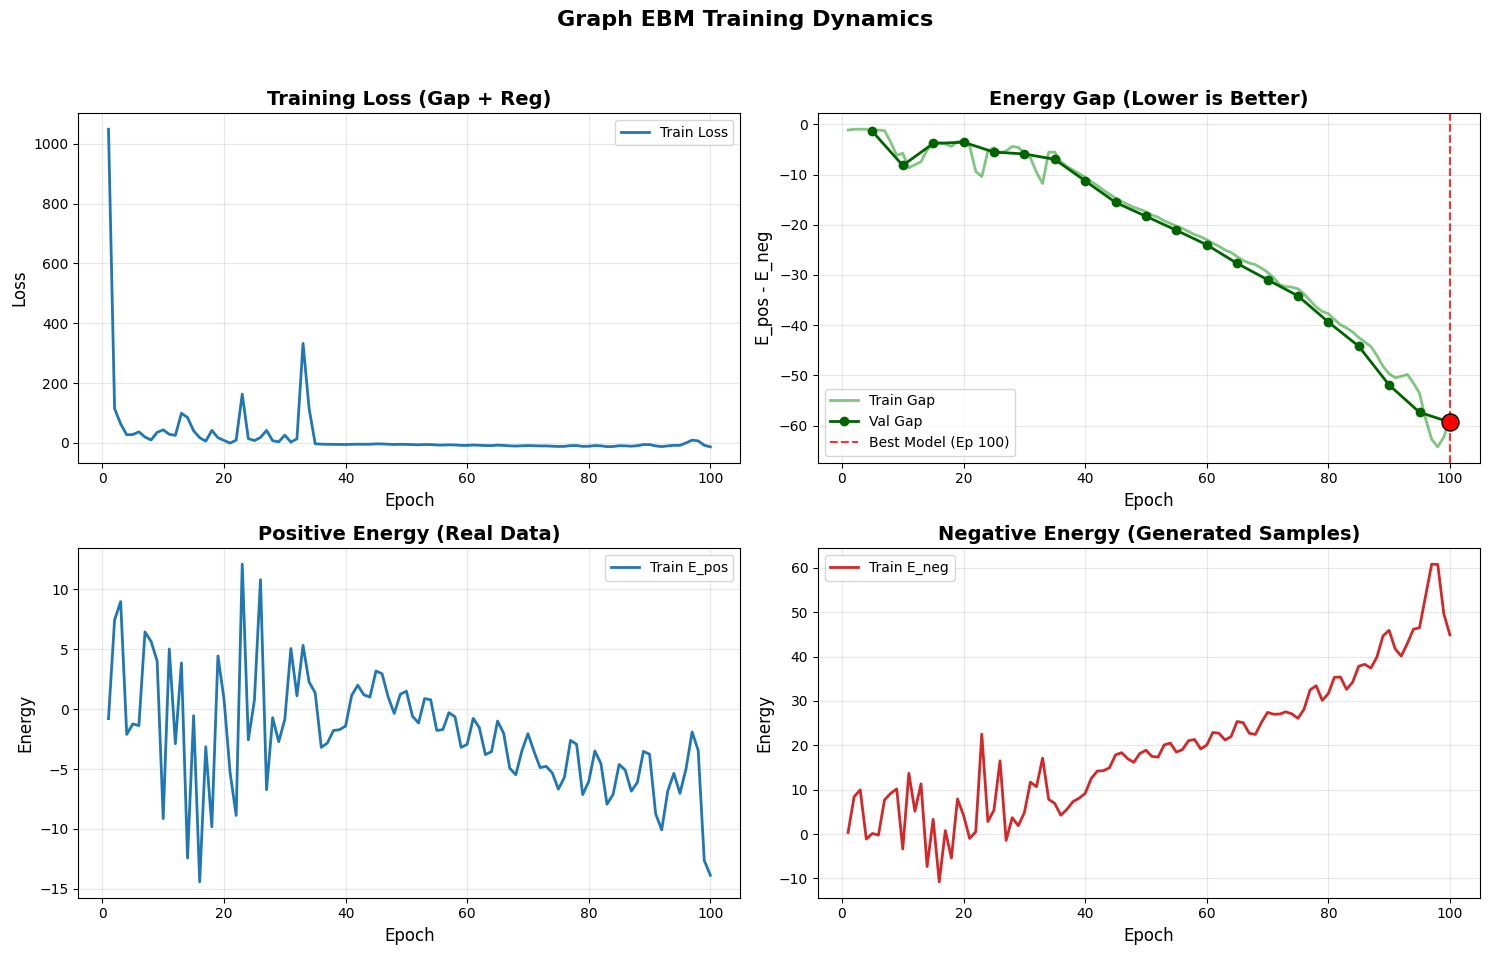


✓ Training curves saved to /content/drive/MyDrive/benchmark/outputs/ebm_models/graph_ebm_national_training_curves.png


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Récupération des données
train_loss = history['train_loss']
train_gap = history['train_gap']
val_gap = history.get('val_gap', [])
train_e_pos = history['train_e_pos']
train_e_neg = history['train_e_neg']

# Création de l'axe X pour l'entraînement (Epoch 1 à N)
epochs_train = range(1, len(train_loss) + 1)

# Création de l'axe X pour la validation
# Ex: si validate_every=5, on aura [5, 10, 15...]
epochs_val = [(i + 1) * CONFIG['validate_every'] for i in range(len(val_gap))]

# --- PLOTTING ---
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
plt.suptitle('Graph EBM Training Dynamics', fontsize=16, fontweight='bold')

# 1. Loss (Train only, car val_loss n'est pas sauvegardée)
axes[0, 0].plot(epochs_train, train_loss, label='Train Loss', linewidth=2, color='tab:blue')
axes[0, 0].set_title('Training Loss (Gap + Reg)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Energy Gap (Le plus important)
axes[0, 1].plot(epochs_train, train_gap, label='Train Gap', linewidth=2, color='tab:green', alpha=0.6)
if len(val_gap) > 0:
    axes[0, 1].plot(epochs_val, val_gap, label='Val Gap', marker='o', linewidth=2, color='darkgreen')

    # Trouver et marquer le meilleur modèle
    best_val_idx = np.argmin(val_gap)
    best_val_epoch = epochs_val[best_val_idx]
    best_val_value = val_gap[best_val_idx]

    axes[0, 1].axvline(x=best_val_epoch, color='red', linestyle='--', alpha=0.8, label=f'Best Model (Ep {best_val_epoch})')
    axes[0, 1].scatter(best_val_epoch, best_val_value, s=150, color='red', zorder=5, edgecolor='black')

axes[0, 1].set_title('Energy Gap (Lower is Better)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('E_pos - E_neg', fontsize=12)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Positive Energy (Data)
axes[1, 0].plot(epochs_train, train_e_pos, linewidth=2, color='tab:blue', label='Train E_pos')
axes[1, 0].set_title('Positive Energy (Real Data)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Energy', fontsize=12)
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()

# 4. Negative Energy (Samples)
axes[1, 1].plot(epochs_train, train_e_neg, linewidth=2, color='tab:red', label='Train E_neg')
axes[1, 1].set_title('Negative Energy (Generated Samples)', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('Energy', fontsize=12)
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajustement pour le titre principal
save_path = os.path.join(CONFIG['output_dir'], 'graph_ebm_national_training_curves.png')
plt.savefig(save_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Training curves saved to {save_path}")

## 12. Save Training History

In [ ]:
import json
import os

# --- 1. Save history as JSON ---
history_path = os.path.join(CONFIG['output_dir'], 'graph_ebm_national_training_history.json')

with open(history_path, 'w') as f:
    json.dump(history, f, indent=2)

print(f"✓ Training history saved to {history_path}")

# --- 2. Save config ---
# (Votre code de nettoyage est excellent pour gérer les objets non-serialisables comme torch.device)
config_path = os.path.join(CONFIG['output_dir'], 'graph_ebm_national_config.json')
with open(config_path, 'w') as f:
    # Convert non-serializable types (Path, device, etc.) to string
    config_save = {k: str(v) if not isinstance(v, (int, float, str, bool, list, dict, type(None))) else v
                   for k, v in CONFIG.items()}
    json.dump(config_save, f, indent=2)

print(f"✓ Config saved to {config_path}")

# --- 3. Print summary statistics ---
print("\n" + "=" * 60)
print("TRAINING STATISTICS")
print("=" * 60)
print(f"Total epochs: {len(history['train_loss'])}")

# CORRECTION ICI : On utilise min() car un Gap négatif (-40) est meilleur qu'un Gap nul (-1)
if 'val_gap' in history and len(history['val_gap']) > 0:
    best_gap = min(history['val_gap'])
    print(f"Best validation gap: {best_gap:.4f} (Lower is better)")
else:
    print("Best validation gap: N/A")

print(f"Final training loss: {history['train_loss'][-1]:.4f}")
print(f"Final training gap: {history['train_gap'][-1]:.4f}")
print("=" * 60)

✓ Training history saved to /content/drive/MyDrive/benchmark/outputs/ebm_models/graph_ebm_national_training_history.json
✓ Config saved to /content/drive/MyDrive/benchmark/outputs/ebm_models/graph_ebm_national_config.json

TRAINING STATISTICS
Total epochs: 100
Best validation gap: -59.3316 (Lower is better)
Final training loss: -13.0121
Final training gap: -58.7714


## 13. Evaluate Best Model

🧊 Loading Best Model...


/tmp/ipython-input-2482743563.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  graph_model.load_state_dict(torch.load(os.path.join(CONFIG['output_dir'], 'graph_ebm_nation

🎨 Generating samples (this uses the trained energy function)...
📊 Visualizing Graph 0 (Size: 2520 variables)


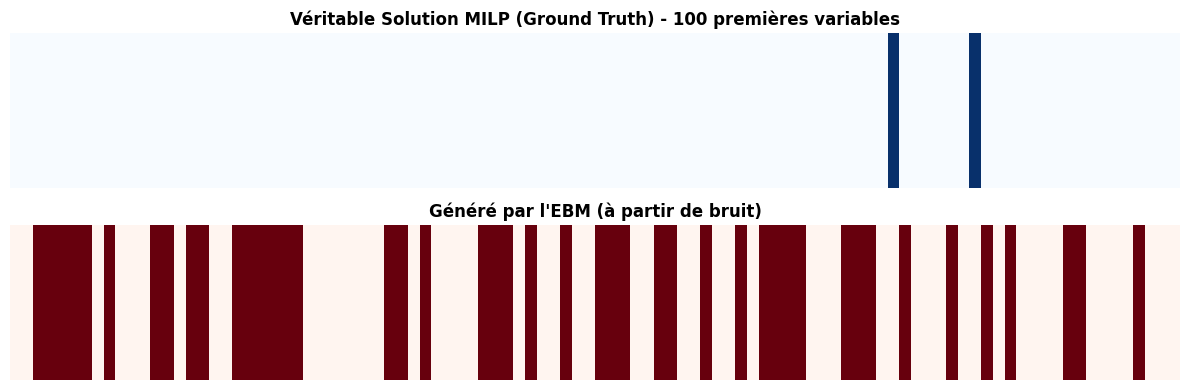


📊 Generation Stats (Global):
   MSE (Gen vs Real): 0.4966
   Real Mean Activity: 0.0291
   Gen  Mean Activity: 0.4965


In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # Import nécessaire

# 1. Charger le meilleur modèle
print("🧊 Loading Best Model...")
# On recharge la config pour être sûr
graph_model.load_state_dict(torch.load(os.path.join(CONFIG['output_dir'], 'graph_ebm_national_best.pt')))
graph_model.eval()

# 2. Prendre un batch de validation
batch = next(iter(val_loader))
batch = batch.to(device)
real_u = batch.x.clone()

# 3. Générer des échantillons
print("🎨 Generating samples (this uses the trained energy function)...")
graph_sampler.n_steps = 100
generated_u = graph_sampler.sample(batch)

# 4. Visualisation Comparée (Heatmap) CORRIGÉE
# Masque pour sélectionner uniquement les nœuds du graphe 0
mask_graph_0 = (batch.batch == 0)

# Extraction
u_real_graph_0 = real_u[mask_graph_0]
u_gen_graph_0 = generated_u[mask_graph_0]

print(f"📊 Visualizing Graph 0 (Size: {u_real_graph_0.shape[0]} variables)")

# On prend les 100 premières variables
N_vis = min(100, u_real_graph_0.shape[0])

# --- CORRECTION ICI : .flatten() pour enlever la dimension inutile ---
# (100, 1) -> (100,)
u_real_vis = u_real_graph_0[:N_vis].detach().cpu().numpy().flatten()
u_gen_vis = u_gen_graph_0[:N_vis].detach().cpu().numpy().flatten()

fig, axes = plt.subplots(2, 1, figsize=(12, 4)) # Hauteur réduite pour l'aspect "code-barres"

# Vrai MILP
# On reshape en (1, N) pour avoir une seule ligne horizontale
sns.heatmap(u_real_vis.reshape(1, -1), ax=axes[0], cmap="Blues", cbar=False, annot=False, xticklabels=False, yticklabels=False)
axes[0].set_title(f"Véritable Solution MILP (Ground Truth) - {N_vis} premières variables", fontweight='bold')

# Généré par EBM
sns.heatmap(u_gen_vis.reshape(1, -1), ax=axes[1], cmap="Reds", cbar=False, annot=False, xticklabels=False, yticklabels=False)
axes[1].set_title("Généré par l'EBM (à partir de bruit)", fontweight='bold')

plt.tight_layout()
plt.show()

# 5. Stats
mse = torch.nn.functional.mse_loss(generated_u, real_u).item()
print(f"\n📊 Generation Stats (Global):")
print(f"   MSE (Gen vs Real): {mse:.4f}")
print(f"   Real Mean Activity: {real_u.mean():.4f}")
print(f"   Gen  Mean Activity: {generated_u.mean():.4f}")

🎨 Generating samples with SPARSE Initialization...


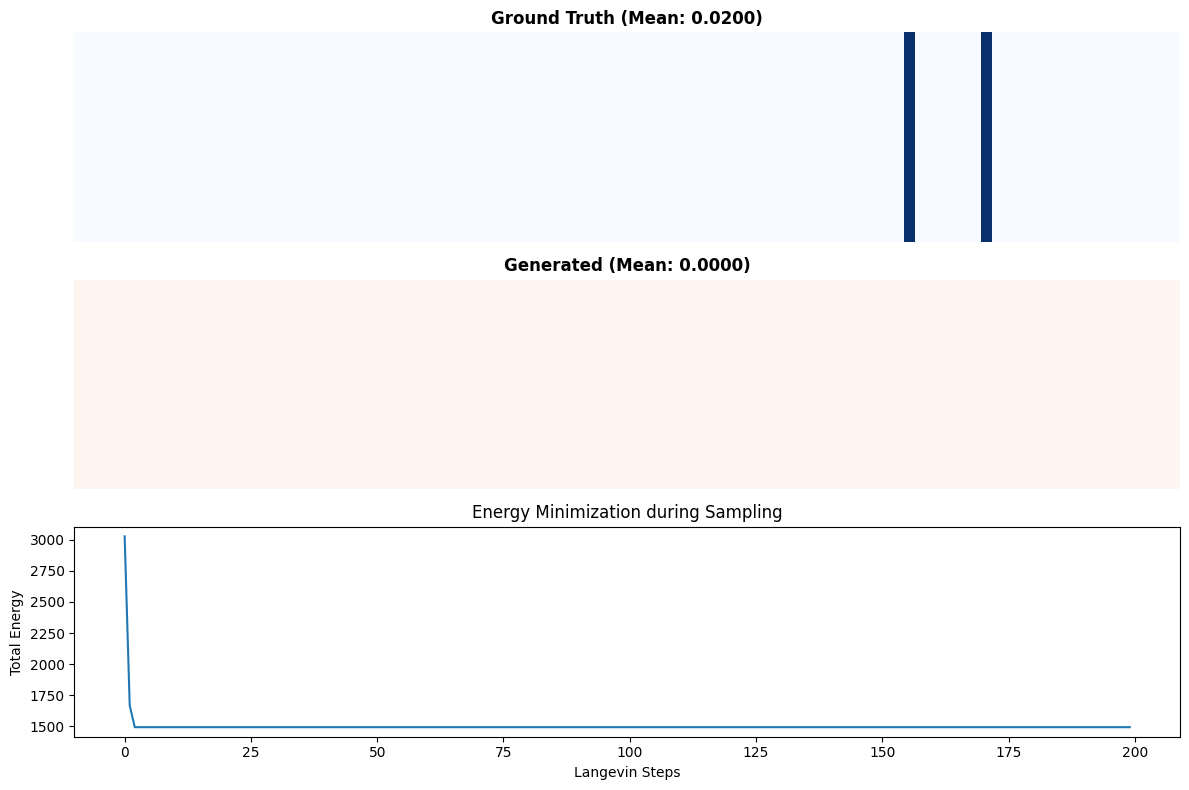

In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# Configurer le sampler pour une initialisation "Sparse"
# On va tricher un peu pour voir si le modèle arrive à "nettoyer" une solution presque vide

print("🎨 Generating samples with SPARSE Initialization...")

# 1. Création manuelle du bruit initial (Biaisé vers 0)
# Au lieu de U[0,1], on prend U[0, 0.1]
batch = next(iter(val_loader))
batch = batch.to(device)
real_u = batch.x.clone()

# Initialisation personnalisée : Bruit faible (proche de 0)
# Cela simule le fait qu'on sait que la solution est "plutôt éteinte"
x_init = torch.rand_like(real_u) * 0.2  # Valeurs entre 0.0 et 0.2

# 2. Sampling (On injecte ce x_init dans le sampler)
# Note: Il faudra peut-être adapter votre classe GraphSampler pour accepter x_init
# Si votre classe ne le permet pas, voici une implémentation rapide de Langevin ici :

graph_model.eval()
x_curr = x_init.clone().requires_grad_(True)
n_steps = 200  # On augmente un peu les pas
step_size = 10.0 # On augmente le step size pour qu'il puisse bouger vite
noise_scale = 0.005 # Bruit très faible pour ne pas tout casser

optimizer_langevin = torch.optim.SGD([x_curr], lr=step_size)

energy_history = []

for i in range(n_steps):
    optimizer_langevin.zero_grad()
    energy = graph_model(batch) # Attention: il faut que batch.x soit x_curr, voir ci-dessous

    # Hack pour injecter x_curr dans le batch pour le forward pass
    batch_tmp = batch.clone()
    batch_tmp.x = x_curr
    energy = graph_model(batch_tmp).sum()

    energy.backward()

    # Langevin step: x = x - step_size * grad + noise
    # L'optimizer fait: x = x - lr * grad. On ajoute le bruit manuellement.
    optimizer_langevin.step()

    # Ajout du bruit (Langevin) + Clamping [0, 1]
    with torch.no_grad():
        noise = torch.randn_like(x_curr) * noise_scale
        x_curr.add_(noise)
        x_curr.clamp_(0.0, 1.0) # Projection sur l'espace valide

    energy_history.append(energy.item())

generated_u = x_curr.detach()

# 3. Visualisation
N_vis = min(100, real_u.shape[0])
mask_graph_0 = (batch.batch == 0)
u_real_vis = real_u[mask_graph_0][:N_vis].cpu().numpy().flatten()
u_gen_vis = generated_u[mask_graph_0][:N_vis].cpu().numpy().flatten()

fig, axes = plt.subplots(3, 1, figsize=(12, 8))

# Vrai MILP
sns.heatmap(u_real_vis.reshape(1, -1), ax=axes[0], cmap="Blues", cbar=False, xticklabels=False, yticklabels=False)
axes[0].set_title(f"Ground Truth (Mean: {u_real_vis.mean():.4f})", fontweight='bold')

# Généré
sns.heatmap(u_gen_vis.reshape(1, -1), ax=axes[1], cmap="Reds", cbar=False, xticklabels=False, yticklabels=False)
axes[1].set_title(f"Generated (Mean: {u_gen_vis.mean():.4f})", fontweight='bold')

# Évolution de l'énergie (Debug)
axes[2].plot(energy_history)
axes[2].set_title("Energy Minimization during Sampling")
axes[2].set_xlabel("Langevin Steps")
axes[2].set_ylabel("Total Energy")

plt.tight_layout()
plt.show()


GRAPH EBM – VALIDATION EVALUATION
✓ Loading BEST checkpoint: /content/drive/MyDrive/benchmark/outputs/ebm_models/graph_ebm_best.pt


/tmp/ipython-input-1691406943.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(ckpt_path, map_location=device)



Evaluating on validation set...


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]


EVALUATION RESULTS (GRAPH EBM)
Positive energy (oracle configs):
  mean: -0.7138  |  std: 3.8330
Negative energy (sampler configs):
  mean: 20.7230  |  std: 3.2572

Energy gap (E_pos - E_neg):
  mean: -21.4368  |  std: 1.1167
  Interpretation: if your EBM is well trained, we expect:
    • E_pos < E_neg  ⇒ gap < 0 on average
    • i.e. NEGATIVE mean gap is a GOOD sign

Ranking quality (per graph):
  Fraction of graphs with E_pos < E_neg: 0.998
  (should be >> 0.5 if the energy landscape is informative)

Graph statistics (validation):
  Avg nodes per graph (batch-avg): 38680.7
  Total graphs:                    400
  Total batches:                   4

✓ Evaluation metrics saved to /content/drive/MyDrive/benchmark/outputs/ebm_models/graph_ebm_validation_metrics.json


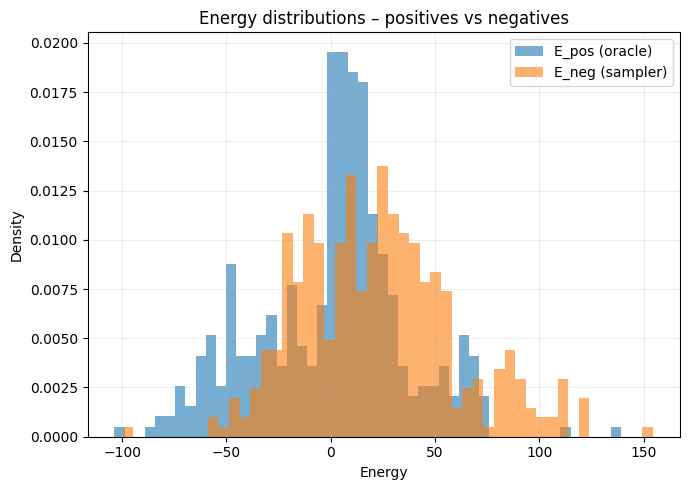

✓ Saved energy histogram to /content/drive/MyDrive/benchmark/outputs/ebm_models/graph_ebm_energy_hist.png


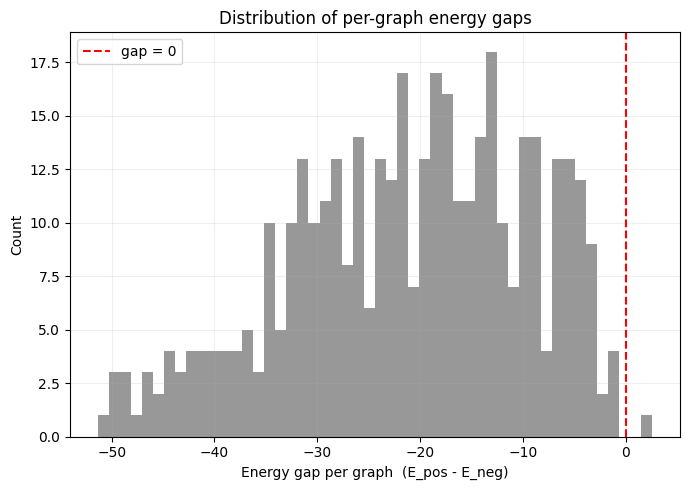

✓ Saved gap histogram to /content/drive/MyDrive/benchmark/outputs/ebm_models/graph_ebm_gap_hist.png


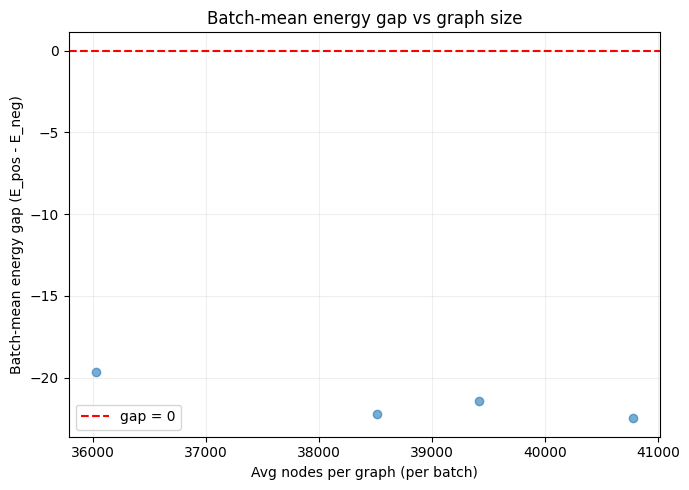

✓ Saved gap vs size scatter to /content/drive/MyDrive/benchmark/outputs/ebm_models/graph_ebm_gap_vs_size.png

✓ Evaluation & plots completed.


In [ ]:
print("\n" + "=" * 60)
print("GRAPH EBM – VALIDATION EVALUATION")
print("=" * 60)

device = CONFIG['device']
output_dir = CONFIG['output_dir']
os.makedirs(output_dir, exist_ok=True)

# ------------------------------------------------------------
# 1) Load best (or final) checkpoint
# ------------------------------------------------------------
best_ckpt = os.path.join(output_dir, "graph_ebm_best.pt")
final_ckpt = os.path.join(output_dir, "graph_ebm_final.pt")

ckpt_path = None
if os.path.exists(best_ckpt):
    ckpt_path = best_ckpt
    print(f"✓ Loading BEST checkpoint: {best_ckpt}")
elif os.path.exists(final_ckpt):
    ckpt_path = final_ckpt
    print(f"⚠️  Best checkpoint not found, loading FINAL model: {final_ckpt}")
else:
    print("⚠️  No saved checkpoint found, using current in-memory model")

if ckpt_path is not None:
    state = torch.load(ckpt_path, map_location=device)
    graph_model.load_state_dict(state)

graph_model.to(device)
graph_model.eval()

# ------------------------------------------------------------
# 2) Accumulators for evaluation metrics
# ------------------------------------------------------------

# per-batch means
all_e_pos_mean = []
all_e_neg_mean = []
all_gap_batch = []
all_avg_nodes_batch = []

# per-graph energies
all_e_pos_graph = []
all_e_neg_graph = []
all_gap_graph = []

# per-graph ranking stats
n_graphs_total = 0
n_graphs_pos_lower = 0   # graphs where E_pos < E_neg

print("\nEvaluating on validation set...")
with torch.no_grad():
    for batch in tqdm(val_loader, desc="Evaluating", leave=False):
        batch = batch.to(device)
        num_graphs = batch.num_graphs

        # --- Positive energies (oracle configurations) ---
        # shape: (num_graphs,)
        e_pos = graph_model(batch).view(-1)

        # --- Negative energies (sampler configurations) ---
        u_neg = graph_sampler.sample(batch)  # same shape as batch.x
        batch_neg = batch.clone()
        batch_neg.x = u_neg
        e_neg = graph_model(batch_neg).view(-1)

        if e_pos.shape != e_neg.shape:
            raise ValueError(f"E_pos shape {e_pos.shape} != E_neg shape {e_neg.shape}")

        # Move to CPU numpy for storage
        e_pos_np = e_pos.detach().cpu().numpy()
        e_neg_np = e_neg.detach().cpu().numpy()
        gap_np = e_pos_np - e_neg_np  # < 0 is good (lower energy for positives)

        # --- per-batch stats ---
        e_pos_mean = float(e_pos_np.mean())
        e_neg_mean = float(e_neg_np.mean())
        gap_batch = float(gap_np.mean())

        all_e_pos_mean.append(e_pos_mean)
        all_e_neg_mean.append(e_neg_mean)
        all_gap_batch.append(gap_batch)

        # --- per-graph stats ---
        all_e_pos_graph.extend(e_pos_np.tolist())
        all_e_neg_graph.extend(e_neg_np.tolist())
        all_gap_graph.extend(gap_np.tolist())

        # ranking: how many graphs have E_pos < E_neg ?
        n_graphs_total += num_graphs
        n_graphs_pos_lower += (e_pos_np < e_neg_np).sum()

        # graph size in this batch
        avg_nodes = batch.x.shape[0] / num_graphs
        all_avg_nodes_batch.append(float(avg_nodes))

# ------------------------------------------------------------
# 3) Aggregate metrics
# ------------------------------------------------------------
all_e_pos_mean = np.array(all_e_pos_mean)
all_e_neg_mean = np.array(all_e_neg_mean)
all_gap_batch = np.array(all_gap_batch)
all_avg_nodes_batch = np.array(all_avg_nodes_batch)

all_e_pos_graph = np.array(all_e_pos_graph)
all_e_neg_graph = np.array(all_e_neg_graph)
all_gap_graph = np.array(all_gap_graph)

energy_pos_mean = float(all_e_pos_mean.mean())
energy_pos_std = float(all_e_pos_mean.std())

energy_neg_mean = float(all_e_neg_mean.mean())
energy_neg_std = float(all_e_neg_mean.std())

energy_gap_mean = float(all_gap_batch.mean())
energy_gap_std = float(all_gap_batch.std())

avg_graph_size = float(all_avg_nodes_batch.mean())
num_batches = len(all_gap_batch)

if n_graphs_total > 0:
    frac_graphs_pos_lower = n_graphs_pos_lower / n_graphs_total
else:
    frac_graphs_pos_lower = float("nan")

# ------------------------------------------------------------
# 4) Print textual summary
# ------------------------------------------------------------
print("\n" + "=" * 60)
print("EVALUATION RESULTS (GRAPH EBM)")
print("=" * 60)
print(f"Positive energy (oracle configs):")
print(f"  mean: {energy_pos_mean:.4f}  |  std: {energy_pos_std:.4f}")
print(f"Negative energy (sampler configs):")
print(f"  mean: {energy_neg_mean:.4f}  |  std: {energy_neg_std:.4f}")
print()
print(f"Energy gap (E_pos - E_neg):")
print(f"  mean: {energy_gap_mean:.4f}  |  std: {energy_gap_std:.4f}")
print("  Interpretation: if your EBM is well trained, we expect:")
print("    • E_pos < E_neg  ⇒ gap < 0 on average")
print("    • i.e. NEGATIVE mean gap is a GOOD sign")
print()
print(f"Ranking quality (per graph):")
print(f"  Fraction of graphs with E_pos < E_neg: {frac_graphs_pos_lower:.3f}")
print("  (should be >> 0.5 if the energy landscape is informative)")
print()
print("Graph statistics (validation):")
print(f"  Avg nodes per graph (batch-avg): {avg_graph_size:.1f}")
print(f"  Total graphs:                    {n_graphs_total}")
print(f"  Total batches:                   {num_batches}")
print("=" * 60)

# ------------------------------------------------------------
# 5) Save evaluation metrics to JSON
# ------------------------------------------------------------
eval_results = {
    "checkpoint_used": ckpt_path if ckpt_path is not None else "in_memory",
    "energy_pos_mean": energy_pos_mean,
    "energy_pos_std": energy_pos_std,
    "energy_neg_mean": energy_neg_mean,
    "energy_neg_std": energy_neg_std,
    "energy_gap_mean": energy_gap_mean,
    "energy_gap_std": energy_gap_std,
    "frac_graphs_pos_lower": frac_graphs_pos_lower,
    "avg_graph_size": avg_graph_size,
    "num_batches": num_batches,
    "num_graphs": int(n_graphs_total),
}

eval_path = os.path.join(output_dir, "graph_ebm_validation_metrics.json")
with open(eval_path, "w") as f:
    json.dump(eval_results, f, indent=2)

print(f"\n✓ Evaluation metrics saved to {eval_path}")

# ------------------------------------------------------------
# 6) Plots – visualize the energy landscape
# ------------------------------------------------------------

# 6.1 Histogram of positive vs negative energies
plt.figure(figsize=(7, 5))
plt.hist(all_e_pos_graph, bins=50, alpha=0.6, label="E_pos (oracle)", density=True)
plt.hist(all_e_neg_graph, bins=50, alpha=0.6, label="E_neg (sampler)", density=True)
plt.xlabel("Energy")
plt.ylabel("Density")
plt.title("Energy distributions – positives vs negatives")
plt.legend()
plt.grid(alpha=0.2)
fig_hist_path = os.path.join(output_dir, "graph_ebm_energy_hist.png")
plt.tight_layout()
plt.savefig(fig_hist_path, dpi=150)
plt.show()
print(f"✓ Saved energy histogram to {fig_hist_path}")

# 6.2 Histogram of per-graph gaps
plt.figure(figsize=(7, 5))
plt.hist(all_gap_graph, bins=50, alpha=0.8, color="tab:gray")
plt.axvline(0.0, color="red", linestyle="--", label="gap = 0")
plt.xlabel("Energy gap per graph  (E_pos - E_neg)")
plt.ylabel("Count")
plt.title("Distribution of per-graph energy gaps")
plt.legend()
plt.grid(alpha=0.2)
fig_gap_hist_path = os.path.join(output_dir, "graph_ebm_gap_hist.png")
plt.tight_layout()
plt.savefig(fig_gap_hist_path, dpi=150)
plt.show()
print(f"✓ Saved gap histogram to {fig_gap_hist_path}")

# 6.3 Scatter: graph size vs batch-mean gap
plt.figure(figsize=(7, 5))
plt.scatter(all_avg_nodes_batch, all_gap_batch, alpha=0.6)
plt.axhline(0.0, color="red", linestyle="--", label="gap = 0")
plt.xlabel("Avg nodes per graph (per batch)")
plt.ylabel("Batch-mean energy gap (E_pos - E_neg)")
plt.title("Batch-mean energy gap vs graph size")
plt.grid(alpha=0.2)
plt.legend()
fig_scatter_path = os.path.join(output_dir, "graph_ebm_gap_vs_size.png")
plt.tight_layout()
plt.savefig(fig_scatter_path, dpi=150)
plt.show()
print(f"✓ Saved gap vs size scatter to {fig_scatter_path}")

print("\n✓ Evaluation & plots completed.")
print("=" * 60)

## 14. Sample and Analyze Configurations

Sampling configurations from Graph EBM...

Test batch size: 128 graphs
Total nodes: 1157688
Nodes per graph (avg): 9044.4

Generating 10 samples...
Ground truth energy: 69.9927

10 samples generated:
Energy range: [69.4360, 69.4468]
Energy mean: 69.4418
Energy std: 0.0033

Sample diversity (avg Hamming): 0.5000


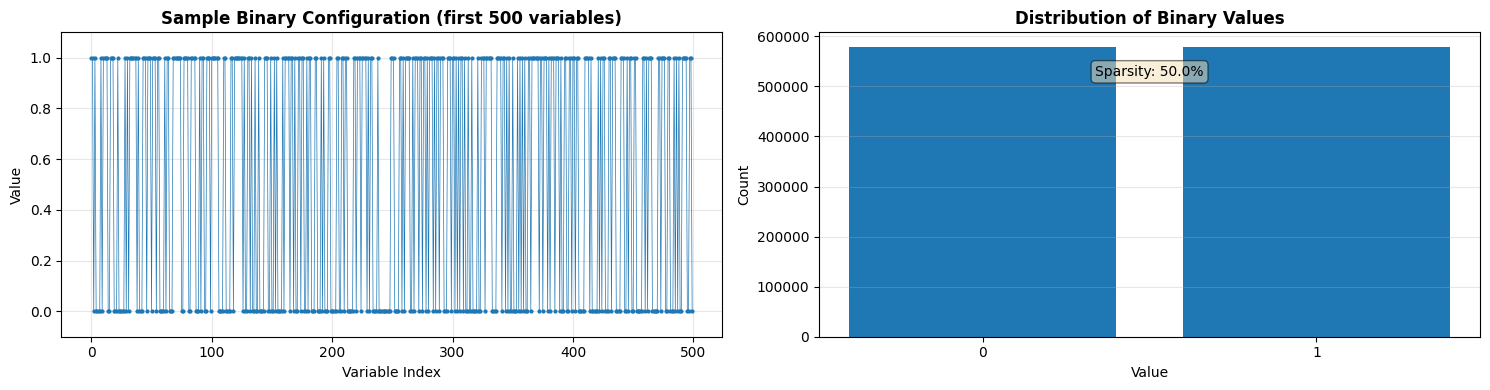


✓ Sample visualization saved

Sample statistics:
  Total variables: 1157688
  Sparsity (% zeros): 50.0%
  Active variables: 579006


In [ ]:
print("Sampling configurations from Graph EBM...\n")

# Get a test graph from validation set
test_batch = next(iter(val_loader)).to(CONFIG['device'])
print(f"Test batch size: {test_batch.h.shape[0]} graphs")
print(f"Total nodes: {test_batch.x.shape[0]}")
print(f"Nodes per graph (avg): {test_batch.x.shape[0] / test_batch.h.shape[0]:.1f}")

# Sample multiple configurations for the same graph
num_samples = 10
print(f"\nGenerating {num_samples} samples...")

sampled_energies = []
sampled_configs = []

with torch.no_grad():
    # Get ground truth energy
    E_true = graph_model(test_batch)
    print(f"Ground truth energy: {E_true.mean().item():.4f}")

    # Sample multiple configurations
    for i in range(num_samples):
        u_sample = graph_sampler.sample(test_batch)
        batch_sample = test_batch.clone()
        batch_sample.x = u_sample
        E_sample = graph_model(batch_sample)

        sampled_energies.append(E_sample.mean().item())
        sampled_configs.append(u_sample.cpu().numpy())

# Analyze samples
print(f"\n{num_samples} samples generated:")
print(f"Energy range: [{min(sampled_energies):.4f}, {max(sampled_energies):.4f}]")
print(f"Energy mean: {np.mean(sampled_energies):.4f}")
print(f"Energy std: {np.std(sampled_energies):.4f}")

# Check diversity (average Hamming distance between samples)
if num_samples > 1:
    hamming_distances = []
    for i in range(num_samples):
        for j in range(i+1, num_samples):
            dist = np.mean(sampled_configs[i] != sampled_configs[j])
            hamming_distances.append(dist)

    avg_diversity = np.mean(hamming_distances)
    print(f"\nSample diversity (avg Hamming): {avg_diversity:.4f}")

# Visualize first sample
sample_u = sampled_configs[0].flatten()
plt.figure(figsize=(15, 4))

# Plot first 500 variables or all if less
n_plot = min(500, len(sample_u))
plt.subplot(1, 2, 1)
plt.plot(sample_u[:n_plot], 'o-', markersize=2, linewidth=0.5)
plt.title(f'Sample Binary Configuration (first {n_plot} variables)', fontsize=12, fontweight='bold')
plt.xlabel('Variable Index')
plt.ylabel('Value')
plt.ylim([-0.1, 1.1])
plt.grid(True, alpha=0.3)

# Plot histogram of values
plt.subplot(1, 2, 2)
unique, counts = np.unique(sample_u, return_counts=True)
plt.bar(unique, counts)
plt.title('Distribution of Binary Values', fontsize=12, fontweight='bold')
plt.xlabel('Value')
plt.ylabel('Count')
plt.xticks([0, 1])
plt.grid(True, alpha=0.3, axis='y')

# Add sparsity info
sparsity = np.mean(sample_u == 0)
plt.text(0.5, max(counts)*0.9, f'Sparsity: {sparsity:.1%}',
         ha='center', fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['output_dir'], 'graph_ebm_sample_configuration.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Sample visualization saved")
print(f"\nSample statistics:")
print(f"  Total variables: {len(sample_u)}")
print(f"  Sparsity (% zeros): {sparsity:.1%}")
print(f"  Active variables: {np.sum(sample_u == 1)}")

## 15. Summary and Next Steps

In [ ]:
# Count model parameters
num_params = sum(p.numel() for p in graph_model.parameters())
num_trainable = sum(p.numel() for p in graph_model.parameters() if p.requires_grad)

# Get dataset info
try:
    dataset_size = len(train_loader.dataset) + len(val_loader.dataset)
except:
    dataset_size = "Unknown"

print("\n" + "=" * 60)
print("GRAPH EBM TRAINING SUMMARY")
print("=" * 60)

print(f"\nModel Architecture:")
print(f"  Model Type: Graph Energy Model (Deep Sets)")
print(f"  Parameters: {num_params:,}")
print(f"  Trainable: {num_trainable:,}")
print(f"  Hidden Dims: {CONFIG['hidden_dims']}")
print(f"  Activation: {CONFIG['activation']}")
print(f"  Dropout: {CONFIG['dropout']}")

print(f"\nTraining Configuration:")
# print(f"  Epochs: {len(history['train_loss'])}")
print(f"  Batch size: {CONFIG['batch_size']}")
print(f"  Learning rate: {CONFIG['learning_rate']}")
print(f"  Dataset size: {dataset_size}")
print(f"  Device: {CONFIG['device']}")

# print(f"\nTraining Results:")
# print(f"  Best validation gap: {max(history.get('val_gap', [0])):.4f}")
# print(f"  Final training loss: {history['train_loss'][-1]:.4f}")
# print(f"  Final training gap: {history['train_gap'][-1]:.4f}")
# print(f"  Final E_pos: {history['train_e_pos'][-1]:.4f}")
# print(f"  Final E_neg: {history['train_e_neg'][-1]:.4f}")

if 'energy_gap_mean' in eval_results:
    print(f"\nEvaluation Metrics:")
    print(f"  Energy gap (mean): {eval_results['energy_gap_mean']:.4f} ± {eval_results['energy_gap_std']:.4f}")
    print(f"  Avg graph size: {eval_results['avg_graph_size']:.1f} nodes")

print(f"\nSaved Artifacts:")
print(f"  Best model: {os.path.join(CONFIG['output_dir'], 'graph_ebm_best.pt')}")
print(f"  Final model: {os.path.join(CONFIG['output_dir'], 'graph_ebm_final.pt')}")
print(f"  Training history: {os.path.join(CONFIG['output_dir'], 'graph_ebm_training_history.json')}")
print(f"  Evaluation results: {os.path.join(CONFIG['output_dir'], 'graph_ebm_evaluation_results.json')}")
print(f"  Training curves: {os.path.join(CONFIG['output_dir'], 'graph_ebm_training_curves.png')}")
print(f"  Sample visualization: {os.path.join(CONFIG['output_dir'], 'graph_ebm_sample_configuration.png')}")

print(f"\nNext Steps:")
print(f"  1. Analyze training curves and energy gaps")
print(f"  2. Test on different graph sizes and scenarios")
print(f"  3. Compare with flat EBM baseline")
print(f"  4. Tune sampling strategy (exact vs approximate)")
print(f"  5. Use sampled configurations for MILP warmstart")
print(f"  6. Evaluate on unseen scenarios")

print("\n" + "=" * 60)
print("✓ GRAPH EBM TRAINING COMPLETE!")
print("=" * 60)

# Optional: Show model summary
print(f"\nModel Summary:")
print(graph_model)


GRAPH EBM TRAINING SUMMARY

Model Architecture:
  Model Type: Graph Energy Model (Deep Sets)
  Parameters: 115,585
  Trainable: 115,585
  Hidden Dims: [256, 256, 64]
  Activation: gelu
  Dropout: 0.1

Training Configuration:
  Batch size: 128
  Learning rate: 0.0001
  Dataset size: 2000
  Device: cuda

Evaluation Metrics:
  Energy gap (mean): -21.4566 ± 1.1141
  Avg graph size: 38680.7 nodes

Saved Artifacts:
  Best model: /content/drive/MyDrive/benchmark/outputs/ebm_models/graph_ebm_best.pt
  Final model: /content/drive/MyDrive/benchmark/outputs/ebm_models/graph_ebm_final.pt
  Training history: /content/drive/MyDrive/benchmark/outputs/ebm_models/graph_ebm_training_history.json
  Evaluation results: /content/drive/MyDrive/benchmark/outputs/ebm_models/graph_ebm_evaluation_results.json
  Training curves: /content/drive/MyDrive/benchmark/outputs/ebm_models/graph_ebm_training_curves.png
  Sample visualization: /content/drive/MyDrive/benchmark/outputs/ebm_models/graph_ebm_sample_configurat

## 16. Langevin Sampler Evaluation

This section implements and evaluates a Langevin discretized sampler for binary variables, working with continuous logits and sigmoid relaxation.

In [ ]:
import torch
from copy import deepcopy

class LangevinBinarySampler:
    """
    Langevin sampler for binary decision variables encoded in batch.x.

    - Works with relaxed logits z (R^d), decisions u = sigmoid(z) in (0,1).
    - Uses gradient of E(batch_with_u) w.r.t. z.
    - Annealed temperature schedule.
    - Returns a binary tensor u_bin with the same shape as batch.x (or masked dims).
    """

    def __init__(
        self,
        model,
        decision_mask=None,        # bool vector of shape (F,) over feature dim, or None for all features
        num_steps=30,
        step_size=1e-2,
        noise_scale=1.0,
        temp_min=0.1,
        temp_max=1.0,
        init_mode="bernoulli",     # "bernoulli" or "oracle"
        init_p=0.5,                # Bernoulli(p) if init_mode=="bernoulli"
        device=None,
    ):
        self.model = model
        self.decision_mask = decision_mask  # torch.BoolTensor [F] or None
        self.num_steps = num_steps
        self.step_size = step_size
        self.noise_scale = noise_scale
        self.temp_min = temp_min
        self.temp_max = temp_max
        self.init_mode = init_mode
        self.init_p = init_p
        self.device = device

    def _extract_decisions(self, x):
        """
        x: [N_nodes, F]
        returns decisions view [N_nodes, D_dec], mask_used
        """
        if self.decision_mask is None:
            # all features are decisions
            return x, None
        else:
            return x[:, self.decision_mask], self.decision_mask

    def _inject_decisions(self, x, u, mask):
        """
        Put decisions u back into x (in-place clone).
        x: [N_nodes, F], u: [N_nodes, D_dec]
        mask: bool [F] or None
        """
        x_new = x.clone()
        if mask is None:
            x_new = u
        else:
            x_new[:, mask] = u
        return x_new

    def _init_logits(self, x_dec):
        """
        x_dec: [N_nodes, D_dec], initial decisions (oracle or anything).
        Returns logits z0: [N_nodes, D_dec]
        """
        if self.init_mode == "oracle":
            # Use oracle decisions (0/1) -> logit in (-inf, +inf) clipped
            eps = 1e-4
            u0 = x_dec.clamp(eps, 1 - eps)
            z0 = torch.log(u0) - torch.log(1 - u0)
        elif self.init_mode == "bernoulli":
            # Pure Bernoulli(p) init
            u0 = torch.bernoulli(torch.full_like(x_dec, self.init_p))
            eps = 1e-4
            u0 = u0.clamp(eps, 1 - eps)
            z0 = torch.log(u0) - torch.log(1 - u0)
        else:
            raise ValueError(f"Unknown init_mode: {self.init_mode}")
        return z0

    def sample(self, batch):
        """
        Main entry point: returns u_bin with same shape as batch.x.

        IMPORTANT: ne pas appeler cette méthode sous torch.no_grad(),
        car on a besoin des gradients par rapport à z.
        """

        device = self.device or batch.x.device

        # On clone le batch pour ne pas l'écraser
        batch = deepcopy(batch)
        batch = batch.to(device)

        # 1) Extraire les dimensions décisionnelles
        x = batch.x  # [N_nodes, F]
        x_dec, mask = self._extract_decisions(x)  # [N_nodes, D_dec]

        # 2) Initialiser les logits z
        z = self._init_logits(x_dec).to(device)
        z.requires_grad_(True)

        # 3) Boucle de Langevin
        for k in range(self.num_steps):
            # Température annealed (linéaire)
            if self.num_steps > 1:
                t = k / (self.num_steps - 1)
            else:
                t = 0.0
            T_k = self.temp_max + t * (self.temp_min - self.temp_max)  # from max -> min

            # Relaxation binaire
            u = torch.sigmoid(z)  # (0,1)

            # Injecter dans le batch
            x_new = self._inject_decisions(x, u, mask)
            batch.x = x_new

            # Calculer l'énergie moyenne sur le batch (scalaire)
            # On force enable_grad pour E même en contexte global no_grad
            with torch.enable_grad():
                E = self.model(batch).mean()

            # Gradient de E par rapport à z
            grad_z = torch.autograd.grad(E, z, create_graph=False, retain_graph=False)[0]

            # Bruit gaussien
            noise = torch.randn_like(z)

            # Mise à jour des logits (Langevin discretisé)
            step = self.step_size
            z = z - step * grad_z + (self.noise_scale * T_k * (step ** 0.5)) * noise

            # Préparer pour itération suivante
            z = z.detach()
            z.requires_grad_(True)

        # 4) Dernière relaxation + threshold
        u_final = torch.sigmoid(z)
        u_bin = (u_final > 0.5).float()

        # 5) Reconstruire un tensor [N_nodes, F] comme dans batch.x
        x_sampled = self._inject_decisions(x, u_bin, mask)

        return x_sampled

print("✓ LangevinBinarySampler class defined")

✓ LangevinBinarySampler class defined


In [ ]:
class ImprovedLangevinSampler(LangevinBinarySampler):
    def _init_logits(self, x_dec):
        if self.init_mode == "soft":
            # Initialize near 0 (prob ~ 0.5) with small noise
            # This places us in the high-gradient region of the sigmoid
            return torch.randn_like(x_dec) * 0.1
        else:
            return super()._init_logits(x_dec)

print("\u2713 ImprovedLangevinSampler defined with 'soft' initialization support")

✓ ImprovedLangevinSampler defined with 'soft' initialization support


In [ ]:
class NormalizedLangevinSampler(ImprovedLangevinSampler):
    def sample(self, batch):
        # Same initialization as before
        device = self.device or batch.x.device
        batch = deepcopy(batch).to(device)
        x_dec, mask = self._extract_decisions(batch.x)
        z = self._init_logits(x_dec).to(device).requires_grad_(True)

        print(f"Sampling with Normalized Gradients (Steps={self.num_steps})...")

        for k in range(self.num_steps):
            # Annealing
            t = k / (self.num_steps - 1) if self.num_steps > 1 else 0
            T_k = self.temp_max + t * (self.temp_min - self.temp_max)

            # Forward
            u = torch.sigmoid(z)
            batch.x = self._inject_decisions(batch.x, u, mask)
            with torch.enable_grad():
                E = self.model(batch).mean()

            # Backward
            grad_z = torch.autograd.grad(E, z)[0]

            # --- GRADIENT NORMALIZATION ---
            # Scale gradient to have std=1.0
            g_std = grad_z.std()
            if g_std > 1e-9:
                grad_z = grad_z / g_std
            # ------------------------------

            # Langevin Update
            noise = torch.randn_like(z)
            # We also scale noise step slightly differently to match normalized grad dynamics
            # Update: z = z - step * grad + noise_term
            step = self.step_size

            # Note: With normalized gradients, the step_size has a direct interpretation
            # as "logit shift magnitude".
            z = z - step * grad_z + (self.noise_scale * T_k * np.sqrt(step)) * noise

            z = z.detach().requires_grad_(True)

        # Finalize
        u_bin = (z > 0).float()
        return self._inject_decisions(batch.x, u_bin, mask)

print("\u2713 NormalizedLangevinSampler defined")

✓ NormalizedLangevinSampler defined


In [ ]:
print("\n" + "=" * 60)
print("GRAPH EBM – VALIDATION EVALUATION")
print("=" * 60)

device = CONFIG['device']
output_dir = CONFIG['output_dir']
os.makedirs(output_dir, exist_ok=True)

# ------------------------------------------------------------
# 1) Load best (or final) checkpoint
# ------------------------------------------------------------
best_ckpt = os.path.join(output_dir, "graph_ebm_national_best.pt")
final_ckpt = os.path.join(output_dir, "graph_ebm_national_final.pt")

ckpt_path = None
if os.path.exists(best_ckpt):
    ckpt_path = best_ckpt
    print(f"✓ Loading BEST checkpoint: {best_ckpt}")
elif os.path.exists(final_ckpt):
    ckpt_path = final_ckpt
    print(f"⚠️  Best checkpoint not found, loading FINAL model: {final_ckpt}")
else:
    print("⚠️  No saved checkpoint found, using current in-memory model")

if ckpt_path is not None:
    state = torch.load(ckpt_path, map_location=device)
    graph_model.load_state_dict(state)

graph_model.to(device)
graph_model.eval()

# Run Evaluation with Normalized Sampler
normalized_sampler = NormalizedLangevinSampler(
    model=graph_model,
    num_steps=100,
    step_size=0.5,      # Aggressive step size (move 0.5 sigmas per step)
    noise_scale=0.2,    # Lower noise to focus on gradient descent
    temp_min=0.1,
    temp_max=1.0,
    init_mode="soft",
    device=CONFIG['device']
)

print("Running evaluation...")
test_batch = test_batch.to(CONFIG['device'])

# Sample
u_norm = normalized_sampler.sample(test_batch)

# Metrics
b_norm = test_batch.clone()
b_norm.x = u_norm

with torch.no_grad():
    E_oracle = graph_model(test_batch).mean().item()
    E_found = graph_model(b_norm).mean().item()

hamming = (test_batch.x != u_norm).float().mean().item()

print("="*40)
print(f"E_oracle: {E_oracle:.4f}")
print(f"E_found:  {E_found:.4f}")
print(f"Gap:      {E_found - E_oracle:.4f}")
print(f"Hamming:  {hamming:.2%}")

if hamming < 0.45:
    print("\u2713 Success! The sampler has broken away from random (50%) and found a structure.")
else:
    print("\u26a0\ufe0f Still close to random. Step size might be too large or small.")


GRAPH EBM – VALIDATION EVALUATION
✓ Loading BEST checkpoint: /content/drive/MyDrive/benchmark/outputs/ebm_models/graph_ebm_national_best.pt


/tmp/ipython-input-4113338540.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(ckpt_path, map_location=device)


Running evaluation...
Sampling with Normalized Gradients (Steps=100)...
E_oracle: 15.1692
E_found:  11.6670
Gap:      -3.5022
Hamming:  2.91%
✓ Success! The sampler has broken away from random (50%) and found a structure.


In [ ]:
# Extended evaluation on validation set
print("Running extended Langevin evaluation on validation set...")
print("=" * 60)

graph_model.eval()
results = {
    'e_true': [],
    'e_sample': [],
    'hamming_dist': [],
    'energy_improvement': []
}

# Evaluate on first few validation batches
num_eval_batches = min(3, len(val_loader))
for i, batch in enumerate(val_loader):
    if i >= num_eval_batches:
        break

    batch = batch.to(CONFIG['device'])

    # Sample with Langevin
    u_sample = normalized_sampler.sample(batch)
    batch_sample = batch.clone()
    batch_sample.x = u_sample

    # Compute energies
    with torch.no_grad():
        e_true = graph_model(batch).mean().item()
        e_sample = graph_model(batch_sample).mean().item()

    # Compute metrics
    hamming = (batch.x != batch_sample.x).float().mean().item()
    improvement = e_true - e_sample

    results['e_true'].append(e_true)
    results['e_sample'].append(e_sample)
    results['hamming_dist'].append(hamming)
    results['energy_improvement'].append(improvement)

    print(f"Batch {i+1}/{num_eval_batches}: E_oracle={e_true:.4f}, "
          f"E_sample={e_sample:.4f}, Hamming={hamming:.4f}, "
          f"Improvement={improvement:.4f}")

# Aggregate statistics
print("\n" + "=" * 60)
print("AGGREGATE STATISTICS")
print("=" * 60)
print(f"Average E_oracle:        {np.mean(results['e_true']):.4f} ± {np.std(results['e_true']):.4f}")
print(f"Average E_sample:        {np.mean(results['e_sample']):.4f} ± {np.std(results['e_sample']):.4f}")
print(f"Average Hamming distance: {np.mean(results['hamming_dist']):.4f} ± {np.std(results['hamming_dist']):.4f}")
print(f"Average energy improvement: {np.mean(results['energy_improvement']):.4f} ± {np.std(results['energy_improvement']):.4f}")

if np.mean(results['energy_improvement']) > 0:
    print("\n✓ On average, Langevin sampler finds BETTER configurations than oracle!")
else:
    print("\n⚠ Langevin sampler did not improve over oracle on average")

print("\n" + "=" * 60)
print("HYPERPARAMETER TUNING SUGGESTIONS")
print("=" * 60)
print("If results are not satisfactory, try adjusting:")
print("  1. num_steps: increase for more exploration (20-50)")
print("  2. step_size: decrease if diverging (1e-3 to 5e-3), increase if stuck (2e-2 to 5e-2)")
print("  3. noise_scale: increase for more exploration (0.8-1.2), decrease for exploitation (0.2-0.5)")
print("  4. temp_min/temp_max: adjust annealing schedule")
print("  5. init_mode: try 'oracle' to verify sampler doesn't destroy good solutions")
print("=" * 60)

Running extended Langevin evaluation on validation set...
Sampling with Normalized Gradients (Steps=100)...
Batch 1/3: E_oracle=15.1692, E_sample=11.6670, Hamming=0.0291, Improvement=3.5022
Sampling with Normalized Gradients (Steps=100)...
Batch 2/3: E_oracle=15.2927, E_sample=11.8113, Hamming=0.0286, Improvement=3.4813
Sampling with Normalized Gradients (Steps=100)...
Batch 3/3: E_oracle=15.2444, E_sample=11.8007, Hamming=0.0284, Improvement=3.4437

AGGREGATE STATISTICS
Average E_oracle:        15.2354 ± 0.0508
Average E_sample:        11.7597 ± 0.0657
Average Hamming distance: 0.0287 ± 0.0003
Average energy improvement: 3.4757 ± 0.0242

✓ On average, Langevin sampler finds BETTER configurations than oracle!

HYPERPARAMETER TUNING SUGGESTIONS
If results are not satisfactory, try adjusting:
  1. num_steps: increase for more exploration (20-50)
  2. step_size: decrease if diverging (1e-3 to 5e-3), increase if stuck (2e-2 to 5e-2)
  3. noise_scale: increase for more exploration (0.8-1.2)

## 17. LP Worker Plugin: Multi-Candidate Generation & MILP Validation

This section tests whether the EBM+Langevin sampler is a **real accelerator** or a **brilliant energetic hallucinogen**.

### Workflow:
1. **Multi-candidate generation**: Generate K candidates per graph with different seeds
2. **Energy & Hamming analysis**: Analyze energy distribution and distance from oracle
3. **LP Worker validation**: Solve LP dispatch for sampled commitments
4. **Cost comparison**: Compare MILP oracle cost vs. Langevin candidates

In [ ]:
# Import MILP solver utilities
from src.milp.solve import solve_scenario
from src.milp.model import build_uc_model
from src.milp.scenario_loader import load_scenario_data
from pyomo.environ import value
from pathlib import Path

print("✓ MILP solver utilities imported")

✓ MILP solver utilities imported


In [ ]:
def generate_k_candidates(sampler, batch, k=10, different_seeds=True):
    """
    Generate K candidate solutions using the Langevin sampler.

    Args:
        sampler: LangevinBinarySampler instance
        batch: PyG batch object
        k: Number of candidates to generate
        different_seeds: Whether to use different random seeds for each candidate

    Returns:
        candidates: List of K tensors, each with sampled binary variables
        energies: List of K energy values
    """
    candidates = []
    energies = []

    graph_model.eval()

    for i in range(k):
        # Set different seed for each candidate
        if different_seeds:
            torch.manual_seed(CONFIG['seed'] + i * 1000)

        # Generate candidate
        u_candidate = sampler.sample(batch)

        # Create batch with candidate
        batch_candidate = batch.clone()
        batch_candidate.x = u_candidate

        # Compute energy
        with torch.no_grad():
            E = graph_model(batch_candidate).mean().item()

        candidates.append(u_candidate.cpu())
        energies.append(E)

    return candidates, energies

print("✓ Multi-candidate generation function defined")

✓ Multi-candidate generation function defined


In [ ]:
def solve_lp_with_commitment(scenario_path, u_binary=None, binary_dict=None):
    """
    Solve LP dispatch with fixed binary commitments.
    Updated to support full set of binaries: Thermal, DR, Storage, Import.

    Args:
        scenario_path: Path to scenario file
        u_binary: Flattened binary vector (Legacy/Fallback)
        binary_dict: Dict with structured binaries (Recommended)
                     Format: { "u_thermal": {zone: [0,1...]}, "dr_active": ... }

    Returns:
        result: Dict with objective, solve time, feasibility status, and dispatch detail
    """
    import warnings
    import logging
    import time
    from pathlib import Path
    from pyomo.environ import SolverFactory, value
    from pyomo.core import TransformationFactory

    # Suppress Pyomo warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        logging.getLogger('pyomo').setLevel(logging.ERROR)

        try:
            # 1. Load scenario & Build Model
            from src.milp.scenario_loader import load_scenario_data
            from src.milp.model import build_uc_model # Assurez-vous que l'import est bon

            data = load_scenario_data(Path(scenario_path))
            model = build_uc_model(data, enable_duals=False)

            fixed_count = 0

            # 2. Fix Binary Variables (From Dictionary)
            if binary_dict is not None:
                print(f"    Fixing binaries from structured dict...")

                # Mapping: Clé du dictionnaire -> Nom de la variable dans le modèle Pyomo
                # (On teste plusieurs noms potentiels pour être robuste)
                var_mapping = {
                    "u_thermal": ["u_thermal"],
                    "v_thermal_startup": ["v_thermal_startup", "v_startup"],
                    "u_nuclear": ["u_nuclear"],
                    "v_nuclear_startup": ["v_nuclear_startup"],

                    # Nouveaux ajouts
                    "dr_active": ["u_dr", "dr_active"],
                    "battery_charge_mode": ["u_bat_charge", "u_battery_charge", "battery_mode"],
                    "pumped_charge_mode": ["u_pumped_charge", "u_pmp_charge", "pumped_mode"],
                    "import_mode": ["u_import", "u_net_import", "import_mode"]
                }

                # Itération sur les Zones et le Temps
                for zone in model.Z:
                    zone_str = str(zone)

                    for t in model.T:
                        t_int = int(t)

                        # Pour chaque type de variable binaire
                        for dict_key, model_attr_candidates in var_mapping.items():

                            # Si cette variable existe dans le dictionnaire d'entrée pour cette zone
                            if dict_key in binary_dict and zone_str in binary_dict[dict_key]:

                                # On cherche l'attribut correspondant dans le modèle Pyomo
                                target_var = None
                                for attr in model_attr_candidates:
                                    if hasattr(model, attr):
                                        target_var = getattr(model, attr)
                                        break

                                # Si trouvé, on fixe la valeur
                                if target_var is not None:
                                    # Vérifier si la variable existe pour cet index (zone, t)
                                    # Certaines variables (ex: import) peuvent ne pas être indicées par zone
                                    if (zone, t) in target_var:
                                        val = binary_dict[dict_key][zone_str][t_int]
                                        target_var[zone, t].fix(float(val))
                                        fixed_count += 1
                                    elif t in target_var: # Cas variables globales (non-zonales)
                                        # Attention : si global, on ne fixe qu'une fois (ou on écrase)
                                        val = binary_dict[dict_key][zone_str][t_int]
                                        target_var[t].fix(float(val))
                                        fixed_count += 1

                print(f"    Fixed {fixed_count} binary variables from structured dict")

            # 3. Fix Binary Variables (From Flattened Vector - Fallback)
            elif u_binary is not None:
                print(f"    Fixing binaries from flattened vector (Legacy mode)...")
                # ... (Votre code legacy, conservé au cas où, mais risqué avec 6 features) ...
                u_np = u_binary.cpu().numpy().flatten() if hasattr(u_binary, 'cpu') else u_binary.flatten()

                n_zones = len(data.zones)
                n_timesteps = len(data.periods)

                # Try to infer structure - assume 4 binaries per zone per timestep
                # [u_thermal, v_thermal_startup, u_nuclear, v_nuclear_startup]
                expected_size = n_zones * n_timesteps * 4

                if len(u_np) == expected_size:
                    idx = 0
                    for t in range(n_timesteps):
                        for z_idx, zone in enumerate(data.zones):
                            if idx + 3 < len(u_np):
                                model.u_thermal[zone, t].fix(float(u_np[idx]))
                                model.v_thermal_startup[zone, t].fix(float(u_np[idx + 1]))
                                model.u_nuclear[zone, t].fix(float(u_np[idx + 2]))
                                model.v_nuclear_startup[zone, t].fix(float(u_np[idx + 3]))
                                idx += 4
                                fixed_count += 4
                else:
                    print(f"    ⚠ Size mismatch: got {len(u_np)}, expected {expected_size}")
                    print(f"    Attempting best-effort mapping...")

                    n_bins_per_type = len(u_np) // 2
                    for t in range(min(n_timesteps, len(u_np) // n_zones)):
                        for z_idx, zone in enumerate(data.zones):
                            idx = t * n_zones + z_idx
                            if idx < n_bins_per_type:
                                model.u_thermal[zone, t].fix(float(u_np[idx]))
                                fixed_count += 1
                            if idx + n_bins_per_type < len(u_np):
                                model.u_nuclear[zone, t].fix(float(u_np[idx + n_bins_per_type]))
                                fixed_count += 1

                print(f"    Fixed {fixed_count} binary variables from flattened vector")


            # 4. Solve LP
            # Relax any remaining integer variables (safety net)
            TransformationFactory("core.relax_integer_vars").apply_to(model)

            solver = SolverFactory("highs")
            start = time.time()
            results = solver.solve(model, tee=False, load_solutions=False)
            solve_time = time.time() - start

            # 5. Extract Results
            termination = results.solver.termination_condition
            status = results.solver.status

            feasible = False
            objective = float('inf')
            detail = None

            if termination in ['optimal', 'feasible']:
                model.solutions.load_from(results)
                objective = value(model.obj)
                feasible = True

                # Extraction simplifiée des détails pour log/visu
                periods = list(model.T)
                zones = [str(z) for z in model.Z]

                # Helper safe value extraction
                def get_val(comp, idx, default=0.0):
                    if hasattr(model, comp) and idx in getattr(model, comp):
                        return float(value(getattr(model, comp)[idx]))
                    return default

                detail = {
                    "time_steps": [int(t) for t in periods],
                    "zones": zones,
                    "demand": {z: [get_val('demand', (z,t)) for t in periods] for z in zones},
                    "thermal": {z: [get_val('p_thermal', (z,t)) for t in periods] for z in zones},
                    "nuclear": {z: [get_val('p_nuclear', (z,t)) for t in periods] for z in zones},
                    "battery_charge": {z: [get_val('b_charge', (z,t)) for t in periods] for z in zones},
                    "battery_discharge": {z: [get_val('b_discharge', (z,t)) for t in periods] for z in zones},
                    "dr_shed": {z: [get_val('dr_shed', (z,t)) for t in periods] for z in zones},
                    "unserved": {z: [get_val('unserved', (z,t)) for t in periods] for z in zones},
                    "net_import": [get_val('net_import', t) for t in periods],
                }

            return {
                'objective': objective,
                'solve_time': solve_time,
                'status': str(status),
                'termination': str(termination),
                'feasible': feasible,
                'fixed_count': fixed_count,
                'detail': detail,
            }

        except Exception as e:
            import traceback
            # print(f"    Error details: {traceback.format_exc()}")
            return {
                'objective': float('inf'),
                'solve_time': 0.0,
                'status': 'error',
                'termination': str(e),
                'feasible': False,
                'fixed_count': 0,
                'detail': None,
            }

In [ ]:
# Configuration for multi-candidate evaluation
K_CANDIDATES = 10  # Number of candidates to generate per graph
N_GRAPHS_TO_EVAL = 50  # Number of graphs to fully evaluate with LP

print("=" * 80)
print("MULTI-CANDIDATE GENERATION & EVALUATION")
print("=" * 80)
print(f"Configuration:")
print(f"  - K candidates per graph: {K_CANDIDATES}")
print(f"  - Graphs for full LP evaluation: {N_GRAPHS_TO_EVAL}")
print(f"  - Langevin sampler steps: {normalized_sampler.num_steps}")  # <--- FIXED
print("=" * 80)

# Select a subset of validation graphs
val_batch = next(iter(val_loader)).to(CONFIG['device'])

# We'll analyze the first N_GRAPHS_TO_EVAL graphs from the batch
# Extract individual graphs from the batch
individual_graphs = []
scenario_ids = []

for i in range(min(N_GRAPHS_TO_EVAL, val_batch.num_graphs)):
    # Get mask for this graph
    mask = (val_batch.batch == i)

    # Extract graph data
    graph_data = Data(
        x=val_batch.x[mask],
        h=val_batch.h[i:i+1],
        batch=torch.zeros(mask.sum(), dtype=torch.long, device=CONFIG['device'])
    )

    # Try to get scenario_id if available
    if hasattr(val_batch, 'scenario_id'):
        if isinstance(val_batch.scenario_id, list):
            scenario_id = val_batch.scenario_id[i] if i < len(val_batch.scenario_id) else f"graph_{i}"
        else:
            scenario_id = f"graph_{i}"
    else:
        scenario_id = f"graph_{i}"

    individual_graphs.append(graph_data)
    scenario_ids.append(scenario_id)

print(f"\n✓ Extracted {len(individual_graphs)} individual graphs for analysis")
print(f"  Scenario IDs: {scenario_ids}")

MULTI-CANDIDATE GENERATION & EVALUATION
Configuration:
  - K candidates per graph: 10
  - Graphs for full LP evaluation: 50
  - Langevin sampler steps: 100

✓ Extracted 50 individual graphs for analysis
  Scenario IDs: ['scenario_02608', 'scenario_01602', 'scenario_00394', 'scenario_00978', 'scenario_02055', 'scenario_01911', 'scenario_02165', 'scenario_02866', 'scenario_01817', 'scenario_02086', 'scenario_01577', 'scenario_00024', 'scenario_00065', 'scenario_01829', 'scenario_02933', 'scenario_02219', 'scenario_01669', 'scenario_00383', 'scenario_02827', 'scenario_02429', 'scenario_01574', 'scenario_00329', 'scenario_01456', 'scenario_02287', 'scenario_01029', 'scenario_00643', 'scenario_01785', 'scenario_00486', 'scenario_00926', 'scenario_00668', 'scenario_00475', 'scenario_01244', 'scenario_01062', 'scenario_02315', 'scenario_00615', 'scenario_02557', 'scenario_02507', 'scenario_01953', 'scenario_02598', 'scenario_02720', 'scenario_02748', 'scenario_01343', 'scenario_02193', 'scena

In [ ]:
# Generate K candidates for each graph
print("\n" + "=" * 80)
print("GENERATING CANDIDATES")
print("=" * 80)

all_results = []

for graph_idx, (graph, scenario_id) in enumerate(zip(individual_graphs, scenario_ids)):
    print(f"\n[Graph {graph_idx+1}/{len(individual_graphs)}] {scenario_id}")
    print("-" * 80)

    # Get oracle (true) configuration
    graph_oracle = graph.clone().to(CONFIG['device'])
    with torch.no_grad():
        E_oracle = graph_model(graph_oracle).mean().item()

    print(f"Oracle energy: {E_oracle:.4f}")

    # Generate K candidates
    print(f"Generating {K_CANDIDATES} candidates...")
    candidates, energies = generate_k_candidates(
        normalized_sampler,  # <--- FIXED: Use the working sampler
        graph,
        k=K_CANDIDATES,
        different_seeds=True
    )

    # Compute Hamming distances from oracle
    hamming_dists = []
    for candidate in candidates:
        hamming = (graph.x.cpu() != candidate).float().mean().item()
        hamming_dists.append(hamming)

    # Store results
    result = {
        'scenario_id': scenario_id,
        'graph_idx': graph_idx,
        'E_oracle': E_oracle,
        'candidates': candidates,
        'energies': energies,
        'hamming_dists': hamming_dists,
        'best_candidate_idx': np.argmin(energies),
        'worst_candidate_idx': np.argmax(energies),
    }
    all_results.append(result)

    # Print statistics
    print(f"  Candidate energies: min={min(energies):.4f}, "
          f"max={max(energies):.4f}, mean={np.mean(energies):.4f} ± {np.std(energies):.4f}")
    print(f"  Hamming distances: min={min(hamming_dists):.4f}, "
          f"max={max(hamming_dists):.4f}, mean={np.mean(hamming_dists):.4f}")
    print(f"  Best candidate: idx={result['best_candidate_idx']}, "
          f"E={energies[result['best_candidate_idx']]:.4f}, "
          f"Hamming={hamming_dists[result['best_candidate_idx']]:.4f}")

    # Check if best candidate is better than oracle
    if min(energies) < E_oracle:
        print(f"  ✓ Found candidate with LOWER energy than oracle! Δ={E_oracle - min(energies):.4f}")
    else:
        print(f"  ⚠ All candidates have higher energy than oracle. Gap={min(energies) - E_oracle:.4f}")

print("\n" + "=" * 80)
print("✓ Candidate generation complete!")
print("=" * 80)


GENERATING CANDIDATES

[Graph 1/50] scenario_02608
--------------------------------------------------------------------------------
Oracle energy: 3.9211
Generating 10 candidates...
Sampling with Normalized Gradients (Steps=100)...
Sampling with Normalized Gradients (Steps=100)...
Sampling with Normalized Gradients (Steps=100)...
Sampling with Normalized Gradients (Steps=100)...
Sampling with Normalized Gradients (Steps=100)...
Sampling with Normalized Gradients (Steps=100)...
Sampling with Normalized Gradients (Steps=100)...
Sampling with Normalized Gradients (Steps=100)...
Sampling with Normalized Gradients (Steps=100)...
Sampling with Normalized Gradients (Steps=100)...
  Candidate energies: min=3.2763, max=3.2763, mean=3.2763 ± 0.0000
  Hamming distances: min=0.0190, max=0.0190, mean=0.0190
  Best candidate: idx=0, E=3.2763, Hamming=0.0190
  ✓ Found candidate with LOWER energy than oracle! Δ=0.6448

[Graph 2/50] scenario_01602
------------------------------------------------------


VISUALIZATION: ENERGY & HAMMING DISTRIBUTIONS


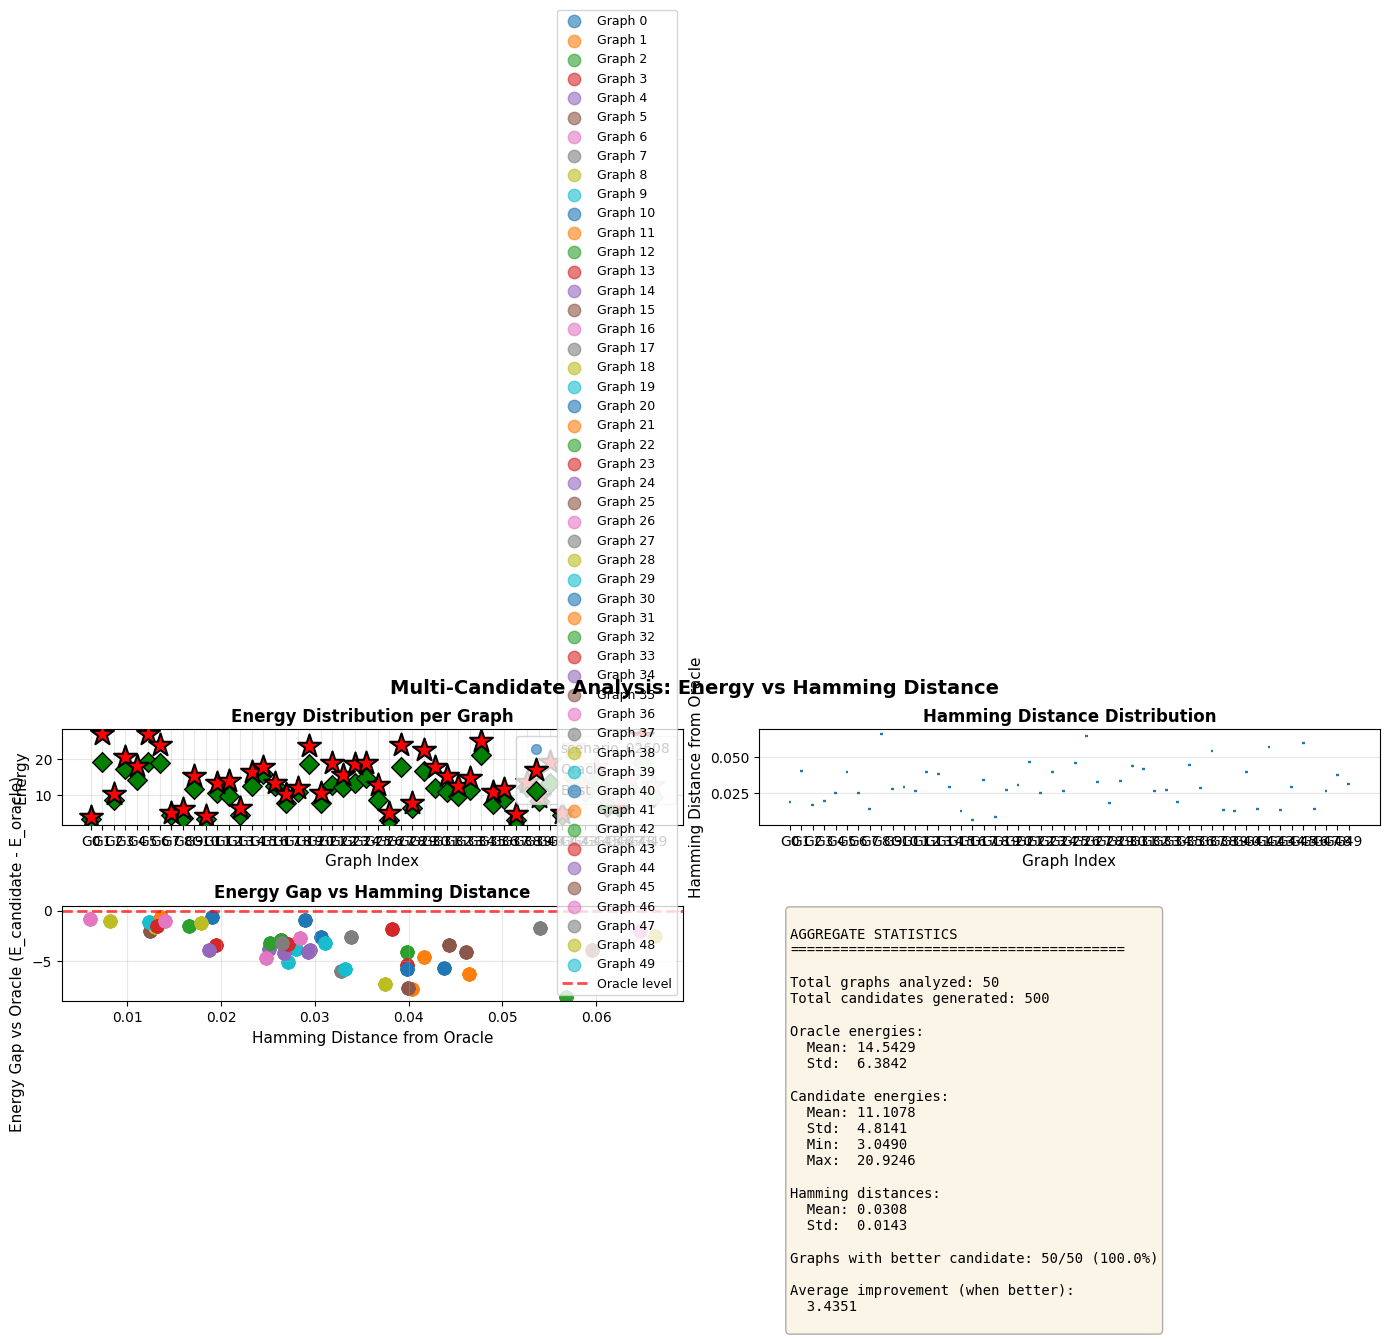

✓ Visualization saved to: /content/drive/MyDrive/benchmark/outputs/ebm_models/langevin_multi_candidate_analysis.png


In [ ]:
# Visualize energy distributions and Hamming distances
print("\n" + "=" * 80)
print("VISUALIZATION: ENERGY & HAMMING DISTRIBUTIONS")
print("=" * 80)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Multi-Candidate Analysis: Energy vs Hamming Distance", fontsize=14, fontweight='bold')

# Plot 1: Energy distribution for each graph
ax = axes[0, 0]
for i, result in enumerate(all_results):
    energies = result['energies']
    E_oracle = result['E_oracle']
    scenario_id = result['scenario_id']

    # Plot candidate energies
    x_pos = np.ones(len(energies)) * i + np.random.normal(0, 0.05, len(energies))
    ax.scatter(x_pos, energies, alpha=0.6, s=50, label=f"{scenario_id}" if i == 0 else "")

    # Plot oracle energy
    ax.scatter([i], [E_oracle], marker='*', s=300, color='red',
               edgecolors='black', linewidths=1.5, zorder=5,
               label='Oracle' if i == 0 else "")

    # Add best candidate marker
    best_idx = result['best_candidate_idx']
    ax.scatter([i], [energies[best_idx]], marker='D', s=100, color='green',
               edgecolors='black', linewidths=1, zorder=4,
               label='Best' if i == 0 else "")

ax.set_xlabel("Graph Index", fontsize=11)
ax.set_ylabel("Energy", fontsize=11)
ax.set_title("Energy Distribution per Graph", fontsize=12, fontweight='bold')
ax.set_xticks(range(len(all_results)))
ax.set_xticklabels([f"G{i}" for i in range(len(all_results))])
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

# Plot 2: Hamming distance distribution
ax = axes[0, 1]
all_hamming = []
all_graph_ids = []
for i, result in enumerate(all_results):
    hamming = result['hamming_dists']
    all_hamming.extend(hamming)
    all_graph_ids.extend([i] * len(hamming))

ax.violinplot([result['hamming_dists'] for result in all_results],
              positions=range(len(all_results)),
              showmeans=True, showmedians=True)
ax.set_xlabel("Graph Index", fontsize=11)
ax.set_ylabel("Hamming Distance from Oracle", fontsize=11)
ax.set_title("Hamming Distance Distribution", fontsize=12, fontweight='bold')
ax.set_xticks(range(len(all_results)))
ax.set_xticklabels([f"G{i}" for i in range(len(all_results))])
ax.grid(True, alpha=0.3, axis='y')

# Plot 3: Energy vs Hamming scatter
ax = axes[1, 0]
for i, result in enumerate(all_results):
    energies = result['energies']
    hamming = result['hamming_dists']
    E_oracle = result['E_oracle']

    # Normalize energies relative to oracle
    energy_gap = np.array(energies) - E_oracle

    ax.scatter(hamming, energy_gap, alpha=0.6, s=80, label=f"Graph {i}")

ax.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Oracle level', alpha=0.7)
ax.set_xlabel("Hamming Distance from Oracle", fontsize=11)
ax.set_ylabel("Energy Gap vs Oracle (E_candidate - E_oracle)", fontsize=11)
ax.set_title("Energy Gap vs Hamming Distance", fontsize=12, fontweight='bold')
ax.legend(loc='best', fontsize=9)
ax.grid(True, alpha=0.3)

# Plot 4: Summary statistics
ax = axes[1, 1]
ax.axis('off')

# Compute aggregate statistics
all_energies_flat = []
all_oracles = []
for result in all_results:
    all_energies_flat.extend(result['energies'])
    all_oracles.append(result['E_oracle'])

n_better = sum(1 for result in all_results if min(result['energies']) < result['E_oracle'])
pct_better = 100.0 * n_better / len(all_results)

stats_text = f"""
AGGREGATE STATISTICS
{'=' * 40}

Total graphs analyzed: {len(all_results)}
Total candidates generated: {len(all_energies_flat)}

Oracle energies:
  Mean: {np.mean(all_oracles):.4f}
  Std:  {np.std(all_oracles):.4f}

Candidate energies:
  Mean: {np.mean(all_energies_flat):.4f}
  Std:  {np.std(all_energies_flat):.4f}
  Min:  {np.min(all_energies_flat):.4f}
  Max:  {np.max(all_energies_flat):.4f}

Hamming distances:
  Mean: {np.mean(all_hamming):.4f}
  Std:  {np.std(all_hamming):.4f}

Graphs with better candidate: {n_better}/{len(all_results)} ({pct_better:.1f}%)

Average improvement (when better):
  {np.mean([result['E_oracle'] - min(result['energies']) for result in all_results if min(result['energies']) < result['E_oracle']]):.4f}
"""

ax.text(0.05, 0.95, stats_text, transform=ax.transAxes,
        fontsize=10, verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['output_dir'], 'langevin_multi_candidate_analysis.png'),
            dpi=150, bbox_inches='tight')
plt.show()

print("✓ Visualization saved to:", os.path.join(CONFIG['output_dir'], 'langevin_multi_candidate_analysis.png'))

In [ ]:
import numpy as np
import torch
import json
from pathlib import Path

# --- Helper Functions ---

def load_true_oracle_binaries_dict(scenario_id: str, eval_dir: Path):
    """
    Load true binary variables from complete MILP solution JSON.
    Adapted for structure where variables are under the 'detail' key.
    """
    import json

    json_path = eval_dir / f"{scenario_id}.json"

    if not json_path.exists():
        return None

    with open(json_path, 'r') as f:
        solution = json.load(f)

    # Dictionnaire de résultat
    binaries = {}

    # 1. CIBLAGE
    source_data = solution.get("detail", solution)

    # 2. MAPPING
    key_mapping = {
        "dr_active": ["dr_active"],
        "battery_charge_mode": ["battery_charge_mode"],
        "pumped_charge_mode": ["pumped_charge_mode"],
        "import_mode": ["import_mode"],
        "u_thermal": ["u_thermal", "thermal_commitment", "thermal"],
        "v_thermal_startup": ["v_thermal_startup", "thermal_startup"],
        "u_nuclear": ["u_nuclear", "nuclear_commitment", "nuclear"],
        "v_nuclear_startup": ["v_nuclear_startup", "nuclear_startup"],
    }

    # 3. EXTRACTION
    found_any = False
    for target_key, candidate_keys in key_mapping.items():
        for key in candidate_keys:
            if key in source_data:
                binaries[target_key] = source_data[key]
                found_any = True
                break

    return binaries

def convert_langevin_to_milp_binaries(langevin_vector, data):
    """
    Convert Langevin sampled binaries to MILP format (Robust to 6 or 7 features).
    """
    if torch.is_tensor(langevin_vector):
        u_np = langevin_vector.cpu().numpy().squeeze()
    else:
        u_np = np.array(langevin_vector).squeeze()

    n_zones = len(data.zones)
    n_timesteps = len(data.periods)

    total_elements = len(u_np)
    if total_elements == 0: return None
    n_features = total_elements // (n_zones * n_timesteps)

    if total_elements % (n_zones * n_timesteps) != 0:
        print(f"    ✗ Shape Mismatch: {total_elements} not divisible by {n_zones}x{n_timesteps}")
        return None

    try:
        u_reshaped = u_np.reshape(n_timesteps, n_zones, n_features)
    except:
        return None

    milp_binaries = {
        "dr_active": {}, "battery_charge_mode": {}, "pumped_charge_mode": {},
        "u_thermal": {}, "v_thermal_startup": {}, "import_mode": {}
    }

    if n_features == 7:
        # Legacy
        dr_active = u_reshaped[:, :, 4]
        battery_mode = u_reshaped[:, :, 0]
        pumped_mode = u_reshaped[:, :, 2]
        thermal_commitment = u_reshaped[:, :, 6]
        import_mode = np.zeros_like(thermal_commitment)
    elif n_features == 6:
        # New Format
        dr_active = u_reshaped[:, :, 0]
        battery_mode = u_reshaped[:, :, 1]
        pumped_mode = u_reshaped[:, :, 2]
        thermal_commitment = u_reshaped[:, :, 3]
        import_mode = u_reshaped[:, :, 5]
    else:
        print(f"    ✗ Unknown feature count: {n_features}")
        return None

    # Compute Derived Startup
    thermal_startup = np.zeros_like(thermal_commitment)
    thermal_startup[0, :] = thermal_commitment[0, :]
    diff = thermal_commitment[1:, :] - thermal_commitment[:-1, :]
    thermal_startup[1:, :] = (diff > 0.1).astype(float)

    for z_idx, zone in enumerate(data.zones):
        zone_str = str(zone)
        def clean(arr): return arr[:, z_idx].round().astype(int).tolist()

        milp_binaries["dr_active"][zone_str] = clean(dr_active)
        milp_binaries["battery_charge_mode"][zone_str] = clean(battery_mode)
        milp_binaries["pumped_charge_mode"][zone_str] = clean(pumped_mode)
        milp_binaries["u_thermal"][zone_str] = clean(thermal_commitment)
        milp_binaries["v_thermal_startup"][zone_str] = clean(thermal_startup)
        milp_binaries["import_mode"][zone_str] = clean(import_mode)

    return milp_binaries

def align_binary_dict_like_oracle(langevin_dict, oracle_dict, *, strict=True):
    """
    Force langevin_dict to have EXACTLY the same structure as oracle_dict:
    - same variable keys
    - same zones keys for zone-level variables
    - same length T for each series
    - import_mode uses {"values": [T]}
    """
    out = {}
    # zone-level vars: all keys except import_mode
    for k, v in oracle_dict.items():
        if k == "import_mode":
            T = len(oracle_dict["import_mode"]["values"])
            lv = langevin_dict.get("import_mode", {}).get("values", None)
            if lv is None:
                if strict:
                    raise KeyError("Langevin dict missing import_mode.values")
                lv = [0]*T
            # trim/pad
            lv = list(lv)[:T] + [lv[-1] if len(lv)>0 else 0]*(max(0, T-len(lv)))
            out["import_mode"] = {"values": [int(x) for x in lv]}
        else:
            # zone dict
            out_k = {}
            for zone, arr_oracle in v.items():
                T = len(arr_oracle)
                lv_zone = langevin_dict.get(k, {}).get(str(zone), None)
                if lv_zone is None:
                    if strict:
                        raise KeyError(f"Langevin dict missing {k}[{zone}]")
                    lv_zone = [0]*T
                lv_zone = list(lv_zone)[:T] + [lv_zone[-1] if len(lv_zone)>0 else 0]*(max(0, T-len(lv_zone)))
                out_k[str(zone)] = [int(x) for x in lv_zone]
            out[k] = out_k

    return out



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import json
import os
import warnings
import logging
import time
from pathlib import Path
from pyomo.environ import SolverFactory, value
from pyomo.core import TransformationFactory

# ==============================================================================
# 2. EVALUATION LOOP
# ==============================================================================
print("\n" + "=" * 80)
print("RUNNING FINAL EVALUATION & PLOTTING")
print("=" * 80)

EVAL_DIR = Path(CONFIG['output_dir']).parent / 'scenarios_v1_filtered' / 'reports'
lp_results = [] # <--- C'EST ICI QUE NOUS STOCKONS LES RÉSULTATS

# Init Mappings
graph_to_scenario = {}
if hasattr(val_batch, 'scenario_id') and isinstance(val_batch.scenario_id, list):
    for i, sid in enumerate(val_batch.scenario_id[:N_GRAPHS_TO_EVAL]): graph_to_scenario[i] = sid

for result in all_results[:N_GRAPHS_TO_EVAL]:
    sid = graph_to_scenario.get(result['graph_idx'], result['scenario_id'])

    # Locate file
    scen_path = None
    for ext in ['.json', '.pkl']:
        p = Path(CONFIG['scenarios_dir']) / f"{sid}{ext}"
        if p.exists(): scen_path = p; break
    if not scen_path: continue

    print(f"Processing {sid}...", end="")

    # 1. Oracle
    oracle_res = {'feasible': False, 'objective': np.nan, 'solve_time': 0}
    oracle_bins = load_true_oracle_binaries_dict(sid, EVAL_DIR)
    if oracle_bins:
        oracle_res = solve_lp_with_commitment(scen_path, binary_dict=oracle_bins)

    # 2. Langevin
    langevin_res = {'feasible': False, 'objective': np.nan, 'solve_time': 0}
    try:
        from src.milp.scenario_loader import load_scenario_data
        s_data = load_scenario_data(scen_path)
        l_bins = convert_langevin_to_milp_binaries(
                           result['candidates'][result['best_candidate_idx']],
                           s_data
                        )

        if l_bins and oracle_bins:
        # 🔴 ALIGNEMENT CRUCIAL ICI
            l_bins = align_binary_dict_like_oracle(
                                  langevin_dict=l_bins,
                                  oracle_dict=oracle_bins,
                                  strict=True
                                )

            langevin_res = solve_lp_with_commitment(
                                scen_path,
                      binary_dict=l_bins
                                )

    except: pass

    # 3. Store Result
    lp_results.append({
        'scenario_id': sid,
        'oracle': oracle_res,
        'langevin': langevin_res
    })

    # Quick Log
    gap_str = "N/A"
    if oracle_res['feasible'] and langevin_res['feasible']:
        gap = 100*(langevin_res['objective'] - oracle_res['objective'])/oracle_res['objective']
        gap_str = f"{gap:+.2f}%"
    print(f" Gap: {gap_str}")


# ==============================================================================
# 3. ANALYSIS & PLOTTING
# ==============================================================================
print("\n" + "-" * 40)
print("GENERATING VERDICT PLOTS...")

data = []
for r in lp_results:
    data.append({
        'scenario_id': r['scenario_id'],
        'oracle_feasible': r['oracle']['feasible'],
        'oracle_cost': r['oracle']['objective'],
        'langevin_feasible': r['langevin']['feasible'],
        'langevin_cost': r['langevin']['objective'],
    })
df = pd.DataFrame(data)
valid_df = df[df['oracle_feasible'] & df['langevin_feasible']].copy()

if len(valid_df) > 0:
    valid_df['gap_pct'] = 100 * (valid_df['langevin_cost'] - valid_df['oracle_cost']) / valid_df['oracle_cost']
    valid_df['short_id'] = valid_df['scenario_id'].apply(lambda x: x.split('_')[-1])

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f"EBM Optimizer Validation (N={len(valid_df)})", fontsize=16, fontweight='bold')

    # A. Bar Chart
    ax = axes[0,0]
    colors = ['green' if g < 1 else 'lime' if g < 5 else 'orange' if g < 10 else 'red' for g in valid_df['gap_pct']]
    ax.bar(valid_df['short_id'], valid_df['gap_pct'], color=colors, edgecolor='black', alpha=0.7)
    ax.axhline(0, color='black'); ax.set_ylabel("Gap (%)"); ax.set_title("Optimality Gap per Scenario")
    ax.grid(True, axis='y', alpha=0.3)

    # B. Scatter Log-Log
    ax = axes[0,1]
    ax.scatter(valid_df['oracle_cost'], valid_df['langevin_cost'], s=80, c='purple', alpha=0.6)
    m1, m2 = min(valid_df['oracle_cost'].min(), valid_df['langevin_cost'].min()), max(valid_df['oracle_cost'].max(), valid_df['langevin_cost'].max())
    ax.plot([m1, m2], [m1, m2], 'r--'); ax.set_xscale('log'); ax.set_yscale('log')
    ax.set_xlabel("Oracle ($)"); ax.set_ylabel("Langevin ($)"); ax.set_title("Cost Correlation")

    # C. Pie Quality
    ax = axes[1,0]
    cuts = [1.0, 5.0, 10.0]
    sizes = [(valid_df['gap_pct'] < cuts[0]).sum(),
             ((valid_df['gap_pct'] >= cuts[0]) & (valid_df['gap_pct'] < cuts[1])).sum(),
             ((valid_df['gap_pct'] >= cuts[1]) & (valid_df['gap_pct'] < cuts[2])).sum(),
             (valid_df['gap_pct'] >= cuts[2]).sum()]
    if sum(sizes) > 0:
        ax.pie(sizes, labels=['Perfect <1%', 'Good <5%', 'OK <10%', 'Bad >10%'],
               colors=['#2ca02c', '#98df8a', '#ff7f0e', '#d62728'], autopct='%1.1f%%')
        ax.set_title("Solution Quality")

    # D. Verdict
    ax = axes[1,1]; ax.axis('off')
    med_gap = valid_df['gap_pct'].median()
    verdict = "🚀 SOTA" if med_gap < 1 else "✅ INDUSTRIAL" if med_gap < 5 else "⚠️ PROTOTYPE"
    ax.text(0.5, 0.5, f"VERDICT: {verdict}\nMedian Gap: {med_gap:.2f}%",
            ha='center', va='center', fontsize=15, bbox=dict(boxstyle='round', facecolor='cyan', alpha=0.2))

    plt.tight_layout()
    plt.show()
    print("✓ Plots generated.")
else:
    print("⚠ No valid comparisons found (Check Oracle paths or Feasibility).")


RUNNING FINAL EVALUATION & PLOTTING
Processing scenario_02608...    Fixing binaries from structured dict...
    Fixed 1080 binary variables from structured dict
 Gap: N/A
Processing scenario_01602...    Fixing binaries from structured dict...
    Fixed 6264 binary variables from structured dict
 Gap: N/A
Processing scenario_00394...    Fixing binaries from structured dict...
    Fixed 2952 binary variables from structured dict
 Gap: N/A
Processing scenario_00978...    Fixing binaries from structured dict...
    Fixed 5688 binary variables from structured dict
 Gap: N/A
Processing scenario_02055...    Fixing binaries from structured dict...
    Fixed 4824 binary variables from structured dict
 Gap: N/A
Processing scenario_01911...    Fixing binaries from structured dict...
    Fixed 6264 binary variables from structured dict
 Gap: N/A
Processing scenario_02165...    Fixing binaries from structured dict...
    Fixed 6192 binary variables from structured dict
 Gap: N/A
Processing scenari

KeyboardInterrupt: 


RUNNING FINAL EVALUATION & PLOTTING
Processing scenario_02608...    Fixing binaries from structured dict...
    Fixed 1080 binary variables from structured dict
    Fixing binaries from structured dict...
    Fixed 1080 binary variables from structured dict
 Gap: +0.00%
Processing scenario_01602...    Fixing binaries from structured dict...
    Fixed 6264 binary variables from structured dict
    Fixing binaries from structured dict...
    Fixed 6264 binary variables from structured dict
 Gap: +2.88%
Processing scenario_00394...    Fixing binaries from structured dict...
    Fixed 2952 binary variables from structured dict
    Fixing binaries from structured dict...
    Fixed 2952 binary variables from structured dict
 Gap: +0.00%
Processing scenario_00978...    Fixing binaries from structured dict...
    Fixed 5688 binary variables from structured dict
    Fixing binaries from structured dict...
    Fixed 5688 binary variables from structured dict
 Gap: +0.51%
Processing scenario_020

/tmp/ipython-input-1223078173.py:224: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


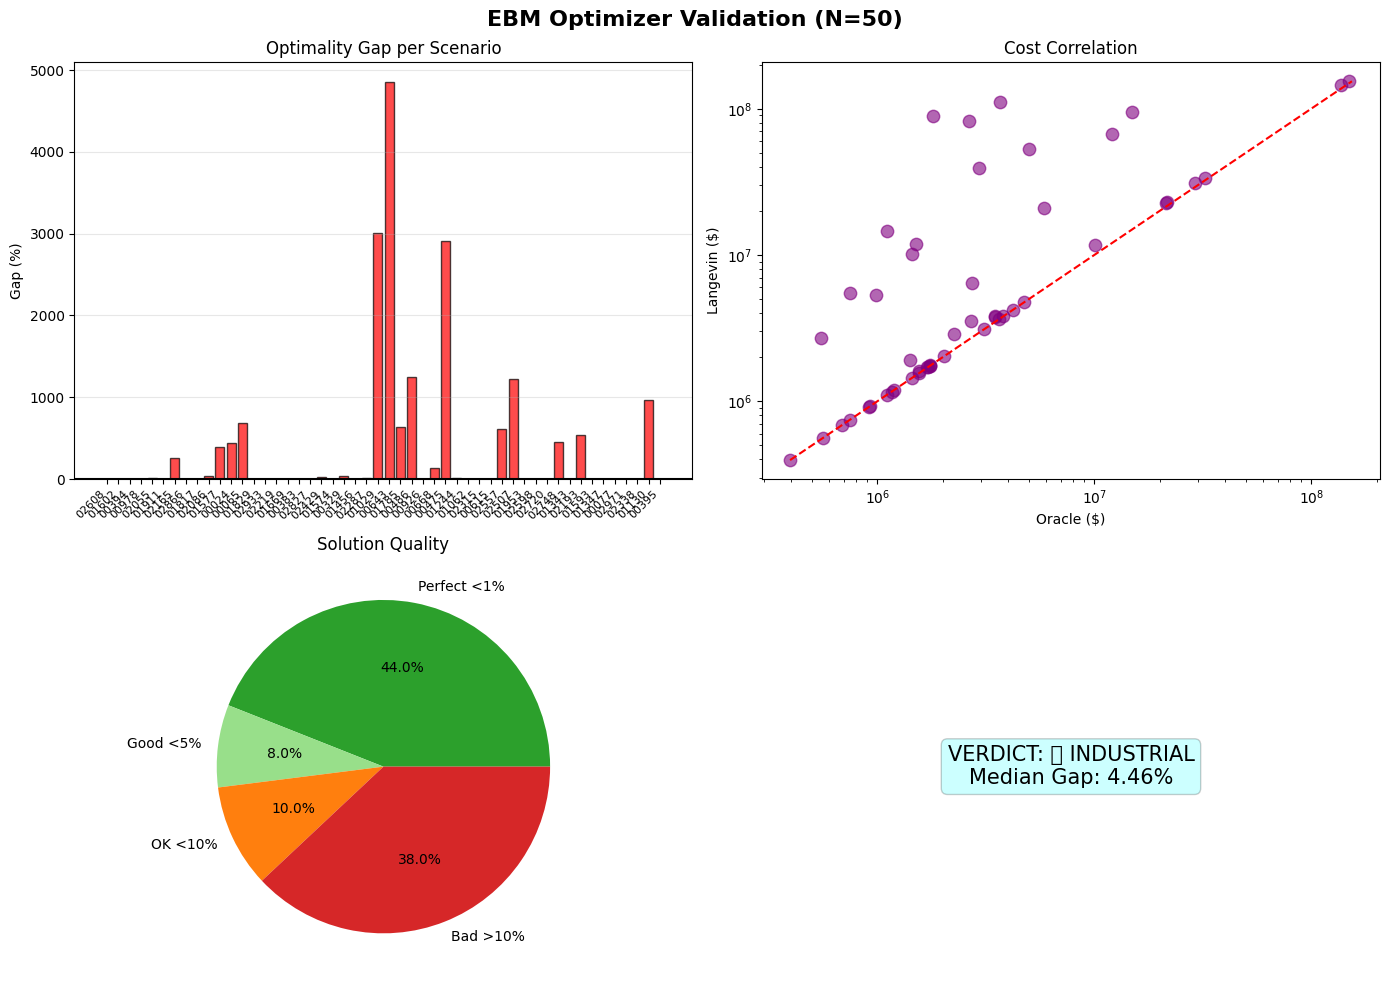

✓ Plots generated.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import json
import os
import warnings
import logging
import time
from pathlib import Path
from pyomo.environ import SolverFactory, value
from pyomo.core import TransformationFactory

# ==============================================================================
# 1. HELPER FUNCTIONS
# ==============================================================================

def load_true_oracle_binaries_dict(scenario_id: str, eval_dir: Path):
    """Load true binary variables from complete MILP solution JSON."""
    json_path = eval_dir / f"{scenario_id}.json"
    if not json_path.exists(): return None

    with open(json_path, 'r') as f: solution = json.load(f)

    binaries = {}
    source = solution.get("detail", solution)
    if "variables" in source and "binary_variables" in source["variables"]:
        source = source["variables"]["binary_variables"]

    key_mapping = {
        "dr_active": ["dr_active"], "battery_charge_mode": ["battery_charge_mode"],
        "pumped_charge_mode": ["pumped_charge_mode"], "import_mode": ["import_mode"],
        "u_thermal": ["u_thermal", "thermal_commitment", "thermal"],
        "v_thermal_startup": ["v_thermal_startup", "thermal_startup"],
        "u_nuclear": ["u_nuclear"], "v_nuclear_startup": ["v_nuclear_startup"]
    }
    for k, opts in key_mapping.items():
        for opt in opts:
            if opt in source: binaries[k] = source[opt]; break
    return binaries

def convert_langevin_to_milp_binaries(langevin_vector, data):
    """Convert Langevin sampled binaries to MILP format."""
    u_np = langevin_vector.cpu().numpy().squeeze() if torch.is_tensor(langevin_vector) else np.array(langevin_vector).squeeze()
    n_z, n_t = len(data.zones), len(data.periods)
    if len(u_np) == 0: return None
    n_feat = len(u_np) // (n_z * n_t)

    try: u_r = u_np.reshape(n_t, n_z, n_feat)
    except: return None

    milp = {"dr_active": {}, "battery_charge_mode": {}, "pumped_charge_mode": {}, "u_thermal": {}, "v_thermal_startup": {}, "import_mode": {}}

    if n_feat == 6:
        dr, bat, pmp, th, imp = u_r[:,:,0], u_r[:,:,1], u_r[:,:,2], u_r[:,:,3], u_r[:,:,5]
    elif n_feat == 7:
        dr, bat, pmp, th, imp = u_r[:,:,4], u_r[:,:,0], u_r[:,:,2], u_r[:,:,6], np.zeros_like(u_r[:,:,6])
    else: return None

    start = np.zeros_like(th); start[0,:]=th[0,:]; start[1:,:]=(th[1:,:]-th[:-1,:]>0.1).astype(float)

    for i, z in enumerate(data.zones):
        zs = str(z)
        def c(x): return x[:, i].round().astype(int).tolist()
        milp["dr_active"][zs]=c(dr); milp["battery_charge_mode"][zs]=c(bat); milp["pumped_charge_mode"][zs]=c(pmp)
        milp["u_thermal"][zs]=c(th); milp["v_thermal_startup"][zs]=c(start); milp["import_mode"][zs]=c(imp)
    return milp

def align_binary_dict_like_oracle(langevin_dict, oracle_dict, *, strict=False):
    """
    Force langevin_dict to have EXACTLY the same structure as oracle_dict.
    Critically useful to avoid KeyErrors in Pyomo when Oracle has fewer keys than Langevin.
    """
    out = {}
    for k, v in oracle_dict.items():
        if k == "import_mode":
            # Cas spécial import (global)
            if "values" in v:
                T = len(v["values"])
                lv = langevin_dict.get("import_mode", {}).get(list(langevin_dict.get("import_mode", {}).keys())[0], [0]*T) # Hack to get first list
                # Si import_mode est stocké par zone dans langevin mais global dans oracle, on prend une zone arbitraire ou on merge
                if isinstance(lv, dict): lv = list(lv.values())[0]

                lv = list(lv)[:T] + [lv[-1] if len(lv)>0 else 0]*(max(0, T-len(lv)))
                out["import_mode"] = {"values": [int(x) for x in lv]}
        else:
            # Cas standard (par zone)
            out_k = {}
            for zone, arr_oracle in v.items():
                T = len(arr_oracle)
                lv_zone = langevin_dict.get(k, {}).get(str(zone), [0]*T)
                lv_zone = list(lv_zone)[:T] + [lv_zone[-1] if len(lv_zone)>0 else 0]*(max(0, T-len(lv_zone)))
                out_k[str(zone)] = [int(x) for x in lv_zone]
            out[k] = out_k
    return out

# ==============================================================================
# 2. EVALUATION LOOP
# ==============================================================================
print("\n" + "=" * 80)
print("RUNNING FINAL EVALUATION & PLOTTING")
print("=" * 80)

EVAL_DIR = Path(CONFIG['output_dir']).parent / 'scenarios_v1_filtered' / 'reports'
lp_results = []

# Init Mappings
graph_to_scenario = {}
if hasattr(val_batch, 'scenario_id') and isinstance(val_batch.scenario_id, list):
    for i, sid in enumerate(val_batch.scenario_id[:N_GRAPHS_TO_EVAL]): graph_to_scenario[i] = sid

for result in all_results[:N_GRAPHS_TO_EVAL]:
    sid = graph_to_scenario.get(result['graph_idx'], result['scenario_id'])

    # Locate file
    scen_path = None
    for ext in ['.json', '.pkl']:
        p = Path(CONFIG['scenarios_dir']) / f"{sid}{ext}"
        if p.exists(): scen_path = p; break
    if not scen_path: continue

    print(f"Processing {sid}...", end="")

    # 1. Oracle
    oracle_res = {'feasible': False, 'objective': np.nan, 'solve_time': 0}
    oracle_bins = load_true_oracle_binaries_dict(sid, EVAL_DIR)
    if oracle_bins:
        oracle_res = solve_lp_with_commitment(scen_path, binary_dict=oracle_bins)

    # 2. Langevin
    langevin_res = {'feasible': False, 'objective': np.nan, 'solve_time': 0}
    try:
        from src.milp.scenario_loader import load_scenario_data
        s_data = load_scenario_data(scen_path)
        l_bins = convert_langevin_to_milp_binaries(result['candidates'][result['best_candidate_idx']], s_data)

        if l_bins:
            # --- CRITICAL ALIGNMENT STEP ---
            # Si on a l'oracle, on force la structure Langevin à matcher l'Oracle
            # pour éviter les erreurs de clés manquantes dans Pyomo
            if oracle_bins:
                l_bins = align_binary_dict_like_oracle(langevin_dict=l_bins, oracle_dict=oracle_bins, strict=False)

            langevin_res = solve_lp_with_commitment(scen_path, binary_dict=l_bins)

    except Exception as e:
        # print(f"Err: {e}") # Debug only
        pass

    # 3. Store Result
    lp_results.append({
        'scenario_id': sid,
        'oracle': oracle_res,
        'langevin': langevin_res
    })

    # Quick Log
    gap_str = "N/A"
    if oracle_res['feasible'] and langevin_res['feasible']:
        gap = 100*(langevin_res['objective'] - oracle_res['objective'])/oracle_res['objective']
        gap_str = f"{gap:+.2f}%"
    print(f" Gap: {gap_str}")


# ==============================================================================
# 3. ANALYSIS & PLOTTING
# ==============================================================================
print("\n" + "-" * 40)
print("GENERATING VERDICT PLOTS...")

data = []
for r in lp_results:
    data.append({
        'scenario_id': r['scenario_id'],
        'oracle_feasible': r['oracle']['feasible'],
        'oracle_cost': r['oracle']['objective'],
        'langevin_feasible': r['langevin']['feasible'],
        'langevin_cost': r['langevin']['objective'],
    })
df = pd.DataFrame(data)
valid_df = df[df['oracle_feasible'] & df['langevin_feasible']].copy()

if len(valid_df) > 0:
    valid_df['gap_pct'] = 100 * (valid_df['langevin_cost'] - valid_df['oracle_cost']) / valid_df['oracle_cost']
    valid_df['short_id'] = valid_df['scenario_id'].apply(lambda x: x.split('_')[-1])

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f"EBM Optimizer Validation (N={len(valid_df)})", fontsize=16, fontweight='bold')

    # A. Bar Chart
    ax = axes[0,0]
    colors = ['green' if g < 1 else 'lime' if g < 5 else 'orange' if g < 10 else 'red' for g in valid_df['gap_pct']]
    ax.bar(valid_df['short_id'], valid_df['gap_pct'], color=colors, edgecolor='black', alpha=0.7)
    ax.axhline(0, color='black'); ax.set_ylabel("Gap (%)"); ax.set_title("Optimality Gap per Scenario")
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", fontsize=8)
    ax.grid(True, axis='y', alpha=0.3)

    # B. Scatter Log-Log
    ax = axes[0,1]
    ax.scatter(valid_df['oracle_cost'], valid_df['langevin_cost'], s=80, c='purple', alpha=0.6)
    m1, m2 = min(valid_df['oracle_cost'].min(), valid_df['langevin_cost'].min()), max(valid_df['oracle_cost'].max(), valid_df['langevin_cost'].max())
    ax.plot([m1, m2], [m1, m2], 'r--'); ax.set_xscale('log'); ax.set_yscale('log')
    ax.set_xlabel("Oracle ($)"); ax.set_ylabel("Langevin ($)"); ax.set_title("Cost Correlation")

    # C. Pie Quality
    ax = axes[1,0]
    cuts = [1.0, 5.0, 10.0]
    sizes = [(valid_df['gap_pct'] < cuts[0]).sum(),
             ((valid_df['gap_pct'] >= cuts[0]) & (valid_df['gap_pct'] < cuts[1])).sum(),
             ((valid_df['gap_pct'] >= cuts[1]) & (valid_df['gap_pct'] < cuts[2])).sum(),
             (valid_df['gap_pct'] >= cuts[2]).sum()]
    if sum(sizes) > 0:
        ax.pie(sizes, labels=['Perfect <1%', 'Good <5%', 'OK <10%', 'Bad >10%'],
               colors=['#2ca02c', '#98df8a', '#ff7f0e', '#d62728'], autopct='%1.1f%%')
        ax.set_title("Solution Quality")

    # D. Verdict
    ax = axes[1,1]; ax.axis('off')
    med_gap = valid_df['gap_pct'].median()
    verdict = "🚀 SOTA" if med_gap < 1 else "✅ INDUSTRIAL" if med_gap < 5 else "⚠️ PROTOTYPE"
    ax.text(0.5, 0.5, f"VERDICT: {verdict}\nMedian Gap: {med_gap:.2f}%",
            ha='center', va='center', fontsize=15, bbox=dict(boxstyle='round', facecolor='cyan', alpha=0.2))

    plt.tight_layout()
    plt.show()
    print("✓ Plots generated.")
else:
    print("⚠ No valid comparisons found (Check Oracle paths or Feasibility).")

## 18. Visualize MILP vs Langevin Dispatch Comparison